In [1]:
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import pickle
import math
import glob
import re
import contextlib
import itertools
import collections
from collections.abc import Mapping
import numpy as np
from numpy import random
import pandas as pd
import tqdm
import torch 
from transformers import AutoModelForSequenceClassification, DefaultDataCollator
from datasets import Dataset
from sklearn import linear_model
import sklearn
from sklearn import pipeline
import scipy
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import plotnine as p9
import seaborn as sns

import pyranges as pr

from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, f1_score

In [2]:
data_path = 'data' #specify data path 

# Functions

## Nucleotide Plotting

In [3]:
def plot_a(ax, base, left_edge, height, color):
    a_polygon_coords = [
        np.array([
           [0.0, 0.0],
           [0.5, 1.0],
           [0.5, 0.8],
           [0.2, 0.0],
        ]),
        np.array([
           [1.0, 0.0],
           [0.5, 1.0],
           [0.5, 0.8],
           [0.8, 0.0],
        ]),
        np.array([
           [0.225, 0.45],
           [0.775, 0.45],
           [0.85, 0.3],
           [0.15, 0.3],
        ])
    ]
    for polygon_coords in a_polygon_coords:
        ax.add_patch(mpl.patches.Polygon((np.array([1,height])[None,:]*polygon_coords
                                                 + np.array([left_edge,base])[None,:]),
                                                facecolor=color, edgecolor=color))


def plot_c(ax, base, left_edge, height, color):
    ax.add_patch(mpl.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=1.3, height=height,
                                            facecolor=color, edgecolor=color))
    ax.add_patch(mpl.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=0.7*1.3, height=0.7*height,
                                            facecolor='white', edgecolor='white'))
    ax.add_patch(mpl.patches.Rectangle(xy=[left_edge+1, base], width=1.0, height=height,
                                            facecolor='white', edgecolor='white', fill=True))


def plot_g(ax, base, left_edge, height, color):
    ax.add_patch(mpl.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=1.3, height=height,
                                            facecolor=color, edgecolor=color))
    ax.add_patch(mpl.patches.Ellipse(xy=[left_edge+0.65, base+0.5*height], width=0.7*1.3, height=0.7*height,
                                            facecolor='white', edgecolor='white'))
    ax.add_patch(mpl.patches.Rectangle(xy=[left_edge+1, base], width=1.0, height=height,
                                            facecolor='white', edgecolor='white', fill=True))
    ax.add_patch(mpl.patches.Rectangle(xy=[left_edge+0.825, base+0.085*height], width=0.174, height=0.415*height,
                                            facecolor=color, edgecolor=color, fill=True))
    ax.add_patch(mpl.patches.Rectangle(xy=[left_edge+0.625, base+0.35*height], width=0.374, height=0.15*height,
                                            facecolor=color, edgecolor=color, fill=True))


def plot_t(ax, base, left_edge, height, color):
    ax.add_patch(mpl.patches.Rectangle(xy=[left_edge+0.4, base],
                  width=0.2, height=height, facecolor=color, edgecolor=color, fill=True))
    ax.add_patch(mpl.patches.Rectangle(xy=[left_edge, base+0.8*height],
                  width=1.0, height=0.2*height, facecolor=color, edgecolor=color, fill=True))

default_colors = {0:'green', 1:'blue', 2:'orange', 3:'red'}
default_plot_funcs = {0:plot_a, 1:plot_c, 2:plot_g, 3:plot_t}
def plot_weights_given_ax(ax, array,
                 figsize=(20,2),
                 height_padding_factor=0.2,
                 length_padding=1.0,
                 subticks_frequency=1.0,
                 colors=default_colors,
                 plot_funcs=default_plot_funcs,
                 highlight={},
                 ylabel=""):
    if len(array.shape)==3:
        array = np.squeeze(array)
    assert len(array.shape)==2, array.shape
    if (array.shape[0]==4 and array.shape[1] != 4):
        array = array.transpose(1,0)
    assert array.shape[1]==4
    max_pos_height = 0.0
    min_neg_height = 0.0
    heights_at_positions = []
    depths_at_positions = []
    for i in range(array.shape[0]):
        #sort from smallest to highest magnitude
        acgt_vals = sorted(enumerate(array[i,:]), key=lambda x: abs(x[1]))
        positive_height_so_far = 0.0
        negative_height_so_far = 0.0
        for letter in acgt_vals:
            plot_func = plot_funcs[letter[0]]
            color=colors[letter[0]]
            if (letter[1] > 0):
                height_so_far = positive_height_so_far
                positive_height_so_far += letter[1]                
            else:
                height_so_far = negative_height_so_far
                negative_height_so_far += letter[1]
            plot_func(ax=ax, base=height_so_far, left_edge=i, height=letter[1], color=color)
        max_pos_height = max(max_pos_height, positive_height_so_far)
        min_neg_height = min(min_neg_height, negative_height_so_far)
        heights_at_positions.append(positive_height_so_far)
        depths_at_positions.append(negative_height_so_far)

    #now highlight any desired positions; the key of
    #the highlight dict should be the color
    for color in highlight:
        for start_pos, end_pos in highlight[color]:
            assert start_pos >= 0.0 and end_pos <= array.shape[0]
            min_depth = np.min(depths_at_positions[start_pos:end_pos])
            max_height = np.max(heights_at_positions[start_pos:end_pos])
            ax.add_patch(
                mpl.patches.Rectangle(xy=[start_pos,min_depth],
                    width=end_pos-start_pos,
                    height=max_height-min_depth,
                    edgecolor=color, fill=False))
            
    ax.set_xlim(-length_padding, array.shape[0]+length_padding)
    ax.xaxis.set_ticks(np.arange(0.0, array.shape[0]+1, subticks_frequency))
    height_padding = max(abs(min_neg_height)*(height_padding_factor),
                         abs(max_pos_height)*(height_padding_factor))
    ax.set_ylim(min_neg_height-height_padding, max_pos_height+height_padding)
    ax.set_ylabel(ylabel)
    ax.yaxis.label.set_fontsize(15)


def plot_weights(array,
                 figsize=(20,2),
                 despine=False,
                 y_lim=None,
                 **kwargs):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111) 
    plot_weights_given_ax(ax=ax, array=array,**kwargs)
    if y_lim:
        ax.set_ylim(y_lim)
    if despine:
        plt.axis('off')
    ax.set_facecolor('white')
    plt.show()
    return fig,ax


def plot_score_track_given_ax(arr, ax, threshold=None, **kwargs):
    ax.plot(np.arange(len(arr)), arr, **kwargs)
    if (threshold is not None):
        ax.plot([0, len(arr)-1], [threshold, threshold])
    ax.set_xlim(0,len(arr)-1)


def plot_score_track(arr, threshold=None, figsize=(20,2), despine=False,y_lim=None,**kwargs):
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111) 
    plot_score_track_given_ax(arr, threshold=threshold, ax=ax, **kwargs) 
    if y_lim:
        ax.set_ylim(y_lim)
    if despine:
        plt.tick_params(
                        axis='x',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        bottom=False,      # ticks along the bottom edge are off
                        top=False,         # ticks along the top edge are off
                        labelbottom=False)
        ax.spines[['right', 'top','bottom']].set_visible(False)
    plt.show()
    return fig,ax

In [4]:
def compute_per_position_ic(ppm, 
                            background=torch.tensor([0.25, 0.25, 0.25, 0.25]), 
                            pseudocount=0):
    alphabet_len = len(background)
    bg = torch.log2(background)*background
    pseudocounted_ppm = (ppm+pseudocount)/(1 + pseudocount*alphabet_len)
    ic = torch.log2(pseudocounted_ppm)*ppm - bg.unsqueeze(0)
    return torch.sum(ic,axis=2)

## Motif finding and analysis

In [13]:
arabic_to_roman = {"1":"I","2":"II","3":"III","4":"IV","5":"V","6":"VI","7":"VII","8":"VIII",
                  "9":"IX","10":"X","11":"XI","12":"XII","13":"XIII","14":"XIV","15":"XV","16":"XVI"}
nuc_to_number = {"A":0,"C":1,"G":2,"T":3}
number_to_nuc = {0:"A",1:"C",2:"G",3:"T"}
nuc_to_revcomp = {"A":"T","T":"A","G":"C","C":"G"}
nuc_to_revcomp_re = {"A":"T","T":"A","G":"C","C":"G",".":".","[":"]","]":"["}

scer_bg = np.array([0.3260, 0.1724, 0.1628, 0.3388])

regex_to_target_dict = {
    "A":np.array([1,0,0,0]),
    "C":np.array([0,1,0,0]),
    "G":np.array([0,0,1,0]),
    "T":np.array([0,0,0,1]),
}

def revcomp_seq(seq):
    return "".join([nuc_to_revcomp[x] for x in seq][::-1])

def one_hot_encode(seq):
    return torch.nn.functional.one_hot(torch.tensor([nuc_to_number[x] for x in seq]),num_classes=4)

def regex_to_targets(motif):
    in_group = False
    motif_targets = []
    for nt in motif:
        if nt == ".":
            motif_targets.append(np.array([1,1,1,1]))
        elif nt == "[":
            in_group = True
            accumulator = np.array([0,0,0,0])
        elif nt == "]":
            in_group = False
            motif_targets.append(accumulator)
        elif in_group:
            accumulator += regex_to_target_dict[nt]
        else:
            motif_targets.append(regex_to_target_dict[nt])
    return np.stack(motif_targets)

def regex_to_instances(motif):
    # convert to a list of "elements"
    in_group = False
    elements = []
    for nt in motif:
        if nt == "[":
            in_group = True
            accumulator = ""
        elif nt == "]":
            in_group = False
            elements.append(accumulator)
        elif in_group:
            accumulator += nt
        else:
            elements.append(nt)
    instances = [""]
    for elem in elements:
        instances_new = []
        # convert wildcard
        if elem == ".":
            elem = "ACGT"
        # create new strings
        for nt in elem:
            for instance in instances:
                instances_new.append(instance + nt)
        instances = instances_new
    return instances

def shuffle_regex(motif, n_shuffles = 10):
    motif_set = set([motif])
    instances = regex_to_instances(motif)
    # convert to a list of "elements"
    in_group = False
    elements = []
    for nt in motif:
        if nt == "[":
            in_group = True
            accumulator = nt
        elif nt == "]":
            in_group = False
            accumulator += nt
            elements.append(accumulator)
        elif in_group:
            accumulator += nt
        else:
            elements.append(nt)
    shuffled_motifs_list = []
    while True:
        # shuffle the regex
        np.random.shuffle(elements)
        shuffled_motif = "".join(elements)
        # ensure that the shuffled motif is new
        if motif_set == motif_set | set([shuffled_motif]):
            continue
        # ensure that the shuffled motif does not match any instances of the original
        if any(re.match(shuffled_motif, instance) for instance in instances):
            continue
        motif_set = motif_set | set([shuffled_motif])
        shuffled_motifs_list.append(shuffled_motif)
        if len(shuffled_motifs_list) == n_shuffles:
            break
    return shuffled_motifs_list 

def snp_regex(motif):
    in_group = False
    elements = []
    for nt in motif:
        if nt == "[":
            in_group = True
            accumulator = ""
        elif nt == "]":
            in_group = False
            elements.append(accumulator)
        elif in_group:
            accumulator += nt
        else:
            elements.append(nt)
    #print(elements)
    elements_clean = [(x if len(x) == 1 else "["+x+"]") for x in elements]
    snp_motifs = []
    for idx,elem in enumerate(elements):
        if elem == ".":
            elem_snp = ["."]
        elif len(elem) > 1:
            elem_snp = ["["+"".join(set("ACTG") - set(elem))+"]"]
            
        else:
            elem_snp = list(set("ACTG") - set(elem))
        for nt in elem_snp:
            snp_motifs.append("".join(elements_clean[:idx] + [nt] + elements_clean[idx+1:]))
    return snp_motifs

def overlapping_matcher(motif, seq):
    result = []
    pos = 0
    pattern = re.compile(motif)
    while len(seq):
        m = pattern.search(seq, pos)
        if m:
            result.append(m)
            pos = m.start() + 1
        else:
            break
    return result 

def find_matches_noduplicates_upstream(dataset, motif):
    # find matches
    match_rows = dataset["five_prime_seq"].apply(lambda seq: overlapping_matcher(motif, seq))
    match_data = dataset[["gene_id","transcript_id","Chromosome","Strand","five_prime_start","five_prime_end","five_prime_seq","concat_start","concat_end","index"]].copy()
    match_data["matches"] = match_rows
    match_data = match_data.loc[match_data["matches"].apply(len) > 0]
    match_data = match_data.explode('matches')
    match_data["match_start"] = match_data['matches'].apply(lambda x: x.span()[0])
    match_data["match_end"] = match_data['matches'].apply(lambda x: x.span()[1])
    match_data["match_abspos"] = match_data.apply(lambda x: x['match_start'] + x["five_prime_start"] if x["Strand"] == "+" else x["five_prime_end"] - 1 - x["match_start"], axis=1)
    match_data["match_seq"] = match_data['matches'].apply(lambda x: x.group())
    # do not doublecount matches, instead associate them to closest gene
    match_data["match_key"] = match_data["Chromosome"].astype('str') + "_" + match_data["match_abspos"].astype('str') + "_" + match_data["Strand"].astype('str')
    match_data = match_data.sort_values("match_start").drop_duplicates(subset=["match_key"],keep="last")
    return match_data

In [14]:
def compute_metrics_for_motif(motif_targets, prbs_match, smooth_prbs):
    target_prbs = (motif_targets*prbs_match).sum(axis=1)
    if smooth_prbs:
        target_prbs = target_prbs + 0.01
        target_prbs = target_prbs/target_prbs.sum(axis=1, keepdims=True)
    avg_target_prbs = torch.mean(target_prbs)
    target_acc = (motif_targets*torch.nn.functional.one_hot(prbs_match.argmax(axis=1),num_classes=4)).sum()/motif_targets.shape[0]
    ce = torch.nn.functional.nll_loss(torch.log(prbs_match), motif_targets.argmax(axis=1))
    return avg_target_prbs, target_acc, ce

def get_metrics_for_motif_site(prbs, targets, match_pos, motif, smooth_prbs = False, get_area_preds=True):
    # process regex motif 
    motif_targets = torch.tensor(regex_to_targets(motif))
    unambig_pos = torch.arange(motif_targets.shape[0])[(motif_targets.sum(axis=1) == 1)] # motif positions with only one option
    # select matching positions
    prbs_match = prbs[match_pos,:]
    targets_match = targets[match_pos]
    # sanity check: the target fits the motif
    assert (torch.nn.functional.one_hot(targets_match,num_classes=4)*motif_targets).sum() == len(motif_targets), print(targets_match, motif_targets)
    # compute metrics
    avg_target_prbs, target_acc, ce = compute_metrics_for_motif(motif_targets, prbs_match, smooth_prbs)
    # compute metrics for unambiguous positions only
    match_pos_unambig = match_pos[0] + unambig_pos
    prbs_match_unambig = prbs_match[unambig_pos,:]
    motif_targets_unambig = motif_targets[unambig_pos,:]
    avg_target_prbs_unambig, target_acc_unambig, ce_unambig = compute_metrics_for_motif(motif_targets_unambig, prbs_match_unambig, smooth_prbs)
    # get general area predictions
    if get_area_preds:
        match_area = torch.tensor(list(range(max(match_pos[0]-5,0),match_pos[-1]+5)))
        prbs_area = prbs[match_area,:]
        targets_area = targets[match_area]
    else:
        prbs_area = None
        targets_area = None
    # return metrics
    return {
            "mean_target_prb":avg_target_prbs.item(),
            "accuracy":target_acc.item(),
            "mean_target_prb_unambig":avg_target_prbs_unambig.item(),
            "cross_entropy_unambig":-ce_unambig.item(),
            "accuracy_unambig":target_acc_unambig.item(),
            "prbs_area":prbs_area,
            "targets_area":targets_area,
        }

def get_conservation_for_motif_site(cons, targets, match_pos, motif):
    # process regex motif
    motif_targets = torch.tensor(regex_to_targets(motif))
    unambig_pos = torch.arange(motif_targets.shape[0])[(motif_targets.sum(axis=1) == 1)] # motif positions with only one option
    # select matching positions
    cons_match = cons[match_pos,:]
    targets_match = targets[match_pos]
    target_cons = (torch.nn.functional.one_hot(targets_match, num_classes=4)*cons_match).max(axis=1)[0]
    target_cons = torch.nan_to_num(target_cons)
    avg_target_cons = target_cons.mean()
    # compute metrics for unambiguous positions only
    match_pos_unambig = match_pos[0] + unambig_pos
    target_cons_unambig = target_cons[unambig_pos]
    avg_target_cons_unambig = target_cons_unambig.mean()
    # get general area predictions
    match_area = torch.tensor(list(range(max(match_pos[0]-5,0),match_pos[-1]+5)))
    cons_area = cons[match_area,:]
    targets_area = targets[match_area]
    # return metrics
    return {
            "mean_target_prb":avg_target_cons.item(),
            "accuracy":avg_target_cons.item(),
            "mean_target_prb_unambig":avg_target_cons_unambig.item(),
            "cross_entropy_unambig":avg_target_cons_unambig.item(),
            "accuracy_unambig":avg_target_cons_unambig.item(),
            "prbs_area":cons_area,
            "targets_area":targets_area,
        }

In [15]:
def get_roc(df, 
            score_col, 
            model, 
            label_col="original", 
            label_pos=None):
    #print(model)
    df = df.query('model == @model')
    scores = np.array(df[score_col])
    if not label_pos:
        labels=np.array(df[label_col])#.astype('int')
    else:
        labels=np.array(df[label_col] == label_pos)
    #print(len(labels), len(df))
    fpr, tpr, thresholds = roc_curve(labels, scores)
    #print(len(fpr))
    prec, rec, thresholds = precision_recall_curve(labels, scores)
    roc_auc = roc_auc_score(labels, scores)
    auc_var = delong_roc_variance(ground_truth=labels.astype('int'), 
                                   predictions = scores)[1]
    auprc = average_precision_score(labels, scores)
    return fpr, tpr, prec, rec, roc_auc, auprc, auc_var

def delong_roc_variance(ground_truth, predictions):
    """
    Computes ROC AUC variance for a single set of predictions
    Args:
       ground_truth: np.array of 0 and 1
       predictions: np.array of floats of the probability of being class 1
    """
    order, label_1_count = compute_ground_truth_statistics(ground_truth)
    predictions_sorted_transposed = predictions[np.newaxis, order]
    aucs, delongcov = fastDeLong(predictions_sorted_transposed, label_1_count)
    assert len(aucs) == 1, "There is a bug in the code, please forward this to the developers"
    return aucs[0], delongcov

def compute_midrank(x):
    """Computes midranks.
    Args:
       x - a 1D numpy array
    Returns:
       array of midranks
    """
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5*(i + j - 1)
        i = j
    T2 = np.empty(N, dtype=float)
    # Note(kazeevn) +1 is due to Python using 0-based indexing
    # instead of 1-based in the AUC formula in the paper
    T2[J] = T + 1
    return T2


def fastDeLong(predictions_sorted_transposed, label_1_count):
    """
    The fast version of DeLong's method for computing the covariance of
    unadjusted AUC.
    Args:
       predictions_sorted_transposed: a 2D numpy.array[n_classifiers, n_examples]
          sorted such as the examples with label "1" are first
    Returns:
       (AUC value, DeLong covariance)
    Reference:
     @article{sun2014fast,
       title={Fast Implementation of DeLong's Algorithm for
              Comparing the Areas Under Correlated Receiver Operating Characteristic Curves},
       author={Xu Sun and Weichao Xu},
       journal={IEEE Signal Processing Letters},
       volume={21},
       number={11},
       pages={1389--1393},
       year={2014},
       publisher={IEEE}
     }
    """
    # Short variables are named as they are in the paper
    m = label_1_count
    n = predictions_sorted_transposed.shape[1] - m
    positive_examples = predictions_sorted_transposed[:, :m]
    negative_examples = predictions_sorted_transposed[:, m:]
    k = predictions_sorted_transposed.shape[0]

    tx = np.empty([k, m], dtype=float)
    ty = np.empty([k, n], dtype=float)
    tz = np.empty([k, m + n], dtype=float)
    for r in range(k):
        tx[r, :] = compute_midrank(positive_examples[r, :])
        ty[r, :] = compute_midrank(negative_examples[r, :])
        tz[r, :] = compute_midrank(predictions_sorted_transposed[r, :])
    aucs = tz[:, :m].sum(axis=1) / m / n - float(m + 1.0) / 2.0 / n
    v01 = (tz[:, :m] - tx[:, :]) / n
    v10 = 1.0 - (tz[:, m:] - ty[:, :]) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    delongcov = sx / m + sy / n
    return aucs, delongcov

def compute_ground_truth_statistics(ground_truth):
    assert np.array_equal(np.unique(ground_truth), [0, 1])
    order = (~ground_truth).argsort()
    label_1_count = int(ground_truth.sum())
    return order, label_1_count

## Loading and processing of matrices

In [16]:
def process_prbs(idx_in_file, nucprobs, one_hots, renormalize, eps=0.0001):
    if renormalize:
        nucprobs = nucprobs + eps
        nucprobs = nucprobs/nucprobs.sum(axis=-1,keepdim=True)
    nucprobs = nucprobs[idx_in_file]
    # onehots
    one_hots = one_hots[idx_in_file]
    return nucprobs, one_hots

def get_prbs(gene_id, id_to_path_nucs, transcript_id=None, renormalize=True, eps=0.0001):
    if not transcript_id:
        # subset snp df
        subset_df = id_to_path_nucs.query('gene_id == "{}"'.format(gene_id))#.iloc[0]["path"]
        # take first transcript
        transcript_id = subset_df.iloc[0]["transcript_id"]
        subset_df = subset_df.query('transcript_id == "{}"'.format(transcript_id))
    else:
        subset_df = id_to_path_nucs.query('transcript_id == "{}"'.format(transcript_id))
    # get path and indices
    path = subset_df.iloc[0]["path"]
    path_one_hots = subset_df.iloc[0]["path_one_hots"]
    idx_in_file = subset_df.iloc[0]["idx_in_file"]
    # load nucprobs
    nucprobs = torch.load(path).float()
    # load onehots
    one_hots = torch.load(path_one_hots)
    return process_prbs(idx_in_file, nucprobs, one_hots, renormalize, eps=eps)

def get_all_prbs(id_to_path_nucs, renormalize=True, eps=0.0001):
    out_dict_nucprobs = {} 
    out_dict_onehots = {}
    # split df by path
    df_gb = id_to_path_nucs.groupby('path')    
    nucdf_per_path = {k:df_gb.get_group(k) for k in df_gb.groups}
    i = 0
    for path in tqdm.tqdm(nucdf_per_path):
        #print(i)
        # subset df
        nucdf_gene = nucdf_per_path[path]
        # load nucprobs
        nucprobs = torch.load(path).float()
        # load onehots
        path_one_hots = nucdf_gene.iloc[0]["path_one_hots"]
        one_hots = torch.load(path_one_hots)
        for _,row in nucdf_gene.iterrows():
            gene_id = row["gene_id"]
            idx_in_file = row["idx_in_file"]
            nucprobs_gene, one_hots_gene = process_prbs(idx_in_file, nucprobs, one_hots, renormalize, eps=eps)
            out_dict_nucprobs[gene_id] = nucprobs_gene
            out_dict_onehots[gene_id] = one_hots_gene
        i += 1
    return out_dict_nucprobs, out_dict_onehots

In [17]:
def get_grads(gene_id, id_to_path_grads, transcript_id=None, correct_gradients=False, reorder=True):
    if not transcript_id:
        # subset snp df
        subset_df = id_to_path_grads.query('gene_id == "{}"'.format(gene_id))#.iloc[0]["path"]
        # take first transcript
        transcript_id = subset_df.iloc[0]["transcript_id"]
        subset_df = subset_df.query('transcript_id == "{}"'.format(transcript_id))
    else:
        subset_df = id_to_path_grads.query('transcript_id == "{}"'.format(transcript_id))
    # get path and indices
    path = subset_df.iloc[0]["path"].replace("nuc_preds","nuc_grads") ## FIXME
    idx_in_file = subset_df.iloc[0]["idx_in_file"]
    # load gradients
    grads = torch.load(path).float()
    grads = grads[idx_in_file] # output --> 1003,4,4,1003 <-- variant
    # reorder
    grads = grads.permute(2,3,0,1) # variant --> 4,1003,1003,4 <-- output
    # Note: this is in BERT-order (ATCG), not standard one-hot order (ACGT)
    if reorder:
        g_reord_col = torch.zeros_like(grads)
        for mapping in [(0,0),(1,2),(2,3),(3,1)]:
            g_reord_col[:,:,:,mapping[0]] = grads[:,:,:,mapping[1]]
        g_reord = torch.zeros_like(g_reord_col)
        for mapping in [(0,0),(1,2),(2,3),(3,1)]:
            g_reord[mapping[0],:,:,:] = g_reord_col[mapping[1],:,:,:]
        grads = g_reord
    if correct_gradients:
        # remove average over possible variant nucleotides
        grads = grads - grads.mean(axis=0,keepdims=True)
    return grads

In [18]:
def extract_snp_effects(interact_mat, start, end, snp_subset_df, use_logit=True, renormalize=True, make_to_matrix=False, eps=0.0001, seqlen=1003):
    interact_mat = interact_mat[start:end+1]
    if renormalize:
        interact_mat = interact_mat + eps
        interact_mat = interact_mat/interact_mat.sum(axis=-1,keepdim=True)
    # prepare snp effect matrix  
    interact_mat_ref = interact_mat[0]
    interact_mat_alt = interact_mat[1:]
    #return interact_mat_alt, interact_mat_ref
    if not use_logit:
        snp_effect_unordered = torch.log(interact_mat_alt) - torch.log(interact_mat_ref)#.unsqueeze(0)
    else:
        #snp_effect_unordered = (torch.log(interact_mat_alt/(1 - interact_mat_alt)) 
        #                        - torch.log(interact_mat_ref/(1 - interact_mat_ref)))
        snp_effect_unordered = (torch.log(interact_mat_alt) - torch.log(1 - interact_mat_alt) 
                                - torch.log(interact_mat_ref) + torch.log(1 - interact_mat_ref))
    # fill it
    snp_effect = torch.zeros((4,seqlen,seqlen,4), device=interact_mat.device) # variant --> 4,1003,1003,4 <-- prediction
    snp_effect[snp_subset_df.iloc[1:]["var_nt_idx"].values, 
               snp_subset_df.iloc[1:]["var_pos"].values] = snp_effect_unordered
    if make_to_matrix:
        snp_effect = torch.abs(snp_effect).amax((0,3))
    return snp_effect


def get_snp_effects(gene_id, snp_df, transcript_id=None, use_logit=True, renormalize=True, make_to_matrix=False, eps=0.0001, seqlen=1003):
    if not transcript_id:
        # subset snp df
        snp_subset_df = snp_df.query('gene_id == "{}"'.format(gene_id))#.iloc[0]["path"]
        # take first transcript
        transcript_id = snp_subset_df.iloc[0]["transcript_id"]
        snp_subset_df = snp_subset_df.query('transcript_id == "{}"'.format(transcript_id))
    else:
        snp_subset_df = snp_df.query('transcript_id == "{}"'.format(transcript_id))
    
    # get path and indices
    path = snp_subset_df.iloc[0]["path"]
    offset = int(path.split("_")[-2])
    start = snp_subset_df["index"].min() - offset
    end = snp_subset_df["index"].max() - offset
    # load matrix
    interact_mat = torch.load(path).to(device="cuda").float()
    return extract_snp_effects(interact_mat, start, end, snp_subset_df, use_logit=use_logit, renormalize=renormalize, make_to_matrix=make_to_matrix, eps=eps, seqlen=seqlen).cpu()

def get_all_snp_effects(snp_df, use_logit=True, renormalize=True, make_to_matrix=True, eps=0.0001, seqlen=1003, idcol="gene_id"):
    out_dict = {}
    # split df by path
    df_gb = snp_df.groupby('path')    
    snp_df_per_path = {k:df_gb.get_group(k) for k in df_gb.groups}
    all_paths = list(snp_df["path"].unique())
    i = 0
    for path in tqdm.tqdm(snp_df_per_path):
        #print(i)
        # load matrix
        interact_mat = torch.load(path).float()
        # subset snp df
        snp_df_path = snp_df_per_path[path]
        # iter through genes
        df_gb = snp_df_path.groupby(idcol)    
        snp_df_per_key = {k:df_gb.get_group(k) for k in df_gb.groups}
        for key in snp_df_per_key:
            # subset snp df
            snp_subset_df = snp_df_per_key[key]
            offset = int(path.split("_")[-2])
            start = snp_subset_df["index"].min() - offset
            end = snp_subset_df["index"].max() - offset
            snp_effect = extract_snp_effects(interact_mat, start, end, snp_subset_df, use_logit=use_logit, renormalize=renormalize, make_to_matrix=make_to_matrix, eps=eps, seqlen=seqlen)
            out_dict[key] = snp_effect#.half()
        i += 1
    return out_dict

def get_all_rowsums(snp_df, use_logit=True, renormalize=True,  eps=0.0001, seqlen=1003, idcol="gene_id"):
    out_dict = {}
    # split df by path
    df_gb = snp_df.groupby('path')    
    snp_df_per_path = {k:df_gb.get_group(k) for k in df_gb.groups}
    all_paths = list(snp_df["path"].unique())
    i = 0
    for path in snp_df_per_path:
        print(i)
        # load matrix
        interact_mat = torch.load(path).float()
        # subset snp df
        snp_df_path = snp_df_per_path[path]
        # iter through genes
        df_gb = snp_df_path.groupby(idcol)    
        snp_df_per_gene = {k:df_gb.get_group(k) for k in df_gb.groups}
        for key in snp_df_per_gene:
            # subset snp df
            snp_subset_df = snp_df_per_gene[key]
            offset = int(path.split("_")[-2])
            start = snp_subset_df["index"].min() - offset
            end = snp_subset_df["index"].max() - offset
            snp_effect = extract_snp_effects(interact_mat, start, end, snp_subset_df, use_logit=use_logit, renormalize=renormalize, make_to_matrix=False, eps=eps, seqlen=seqlen)
            snp_effect = torch.abs(snp_effect).amax(axis=3) # max over targets
            # remove diagonal
            for j in range(snp_effect.shape[0]):
                snp_effect[j].fill_diagonal_(0)
            # compute row sum
            snp_effect = snp_effect.mean(axis=-1)
            out_dict[key] = snp_effect#.half()
        i += 1
    return out_dict

In [19]:
def plot_area(start, end, snp_effect, make_to_matrix=True, vmax=None, remove_diag=True, size=None, savepath=None, cbar=True, return_matrix=False):
    if make_to_matrix:
        matrix = torch.abs(snp_effect).amax((0,3))[start:end,start:end].numpy(force=True)
    else:
        matrix = snp_effect[start:end,start:end].clone().numpy(force=True)
    if remove_diag:
        np.fill_diagonal(matrix,0)
    if return_matrix:
        return matrix
        
    fig, ax = plt.subplots()
    if size is not None:
        fig.set_size_inches(size,size)
        
    ax.set_aspect('equal')
    ax = sns.heatmap(matrix, cmap='coolwarm', vmax=vmax, cbar=cbar)
    
    if savepath is not None:
        fig.savefig(savepath, dpi=300)

def plot_with_nucs(start, end, snp_effect, sequence, make_to_matrix=True, vmax=None, remove_diag=True, size=None, savepath=None, cbar=True):
    fig, ax = plt.subplots()
    if size is not None:
        fig.set_size_inches(size,size)
    
    if make_to_matrix:
        matrix = torch.abs(snp_effect).amax((0,3))[start:end,start:end].numpy(force=True)
    else:
        matrix = snp_effect[start:end,start:end].clone().numpy(force=True)
    if remove_diag:
        np.fill_diagonal(matrix,0)
    ax = sns.heatmap(matrix, cmap='coolwarm', vmax=vmax, cbar=cbar)

    tick_positions = np.arange(len(sequence[start:end])) + 0.5 # Center the ticks
    ax.set_aspect('equal')
    ax.set_xticks(tick_positions)
    ax.set_yticks(tick_positions)
    
    ax.set_xticklabels(list(sequence[start:end]), fontsize=10, rotation=0)
    ax.set_yticklabels(list(sequence[start:end]), fontsize=10, rotation=0)
    
    if savepath is not None:
        fig.savefig(savepath, dpi=300)

In [20]:
# compute the blockyness
def blockyness_qtl(block, qtl=0.25):
    return block.quantile(qtl)
#
def compute_blockyness(dataset, all_snp_effects, fun, kmer_size=6, seqlen=1003, idcol="gene_id"):
    block_metrics = []
    diag_mask = ~torch.eye(kmer_size).bool()
    for _,row in tqdm.tqdm(dataset.iterrows()):
        block_metric = torch.zeros(seqlen-kmer_size+1)
        key = row[idcol]
        for i in range(seqlen-kmer_size+1):
            block = all_snp_effects[key][i:i+kmer_size,i:i+kmer_size]
            block_metric[i] = fun(block[diag_mask])
        block_metrics.append(block_metric)
    block_metrics = torch.stack(block_metrics,axis=0)
    return block_metrics

# Kircher

In [21]:
# checks if a dataset has no N or similar
def check_valid(dataset, seq_col):
    valid_nt_count = np.stack([np.array(dataset[seq_col].str.count(nt)) for nt in ["A","C","G","T"]],axis=1).sum(axis=1)
    return valid_nt_count == np.array(dataset[seq_col].str.len())

def variant_to_track(df):
    arr = torch.zeros((len(set(df["var_rel_pos"])),4))
    refs = torch.zeros((len(set(df["var_rel_pos"])),4))
    min_pos = df["var_rel_pos"].min()
    for _,row in df.sort_values('var_rel_pos').iterrows():
        log2fc = row["log2FC"] 
        ref = row["Ref"]
        alt = row["Alt"]
        if row["Strand"] == "-":
            ref = nuc_to_revcomp[ref]
            alt = nuc_to_revcomp[alt]
        arr[row["var_rel_pos"]-min_pos,nuc_to_number[alt]] = log2fc
        refs[row["var_rel_pos"]-min_pos,nuc_to_number[ref]] = 1
    return arr, refs

## Load sequence data

In [22]:
seq_col = "five_prime_seq"
seq_len = 2003
dataset = pd.read_parquet(os.path.join(data_path, 'homo_sapiens_five_prime_rel_cds.parquet'))
dataset[seq_col] = dataset[seq_col].str[-seq_len:] # truncate longer left
dataset = dataset.loc[dataset[seq_col].str.len() == seq_len] # remove shorter
dataset = dataset.loc[check_valid(dataset, seq_col)].reset_index(drop=True) # remove nonsense
dataset["five_prime_start"] = dataset.apply(lambda x: x["five_prime_start"] + 8000 if x["Strand"] == "+" else x["five_prime_start"],axis=1)
dataset["five_prime_end"] = dataset.apply(lambda x: x["five_prime_end"] - 8000 if x["Strand"] == "-" else x["five_prime_end"],axis=1)

## Load mutagenesis data

In [23]:
base_path_data = os.path.join(data_path, "Kircher_saturation_mutagenesis/")

nuc_to_number = {"A":0,"C":1,"G":2,"T":3}

locus_list = []
for path in glob.glob(base_path_data + "*/*.tsv"):
    locus = path.split("/")[-1].split("_")[-1].split(".")[0]
    locus_df = pd.read_csv(path,sep="\t", names=["Chromosome", 
                                                  "Pos_hg38",
                                                  "Ref",
                                                  "Alt",
                                                  "log2FC",
                                                  "Variance"])
    locus_df["Locus"] = locus
    locus_list.append(locus_df)
kircher_df = pd.concat(locus_list)

kircher_df = kircher_df.reset_index(drop=True).rename(columns={"Locus":"locus","Pos_hg38":"variant_pos"})
kircher_df["Chromosome"] = kircher_df["Chromosome"].str.replace("chr","")
kircher_df["variant_pos_zerobased"] = kircher_df["variant_pos"] - 1

kircher_merged = dataset.merge(kircher_df,on="Chromosome").query('variant_pos_zerobased > five_prime_start and variant_pos_zerobased < five_prime_end')
kircher_merged["var_rel_pos"] = (kircher_merged
                                 .apply(lambda x: x["variant_pos_zerobased"]-x["five_prime_start"] if x["Strand"] == "+" else seq_len-((x["variant_pos_zerobased"]+1)-x["five_prime_start"]), axis=1)
)

In [24]:
kircher_merged["id"] =  kircher_merged["locus"] + "_" +  kircher_merged["variant_pos_zerobased"].astype('str')

In [25]:
kircher_seqs = kircher_merged.groupby(["locus","gene_id","transcript_id","five_prime_seq","Chromosome","five_prime_start","five_prime_end","Strand"])["var_rel_pos"].agg(["min","max"]).reset_index()

In [26]:
kircher_seqs_nodup = kircher_seqs.sort_values(["locus","min"]).drop_duplicates('locus',keep="last").query('locus != "TERT-HEK293T"').reset_index(drop=True).reset_index()

In [19]:
kircher_seqs_nodup.to_parquet(os.path.join(data_path, "kircher_sequences.parquet")

In [28]:
kircher_positions = pd.read_parquet(os.path.join(data_path, 'kircher_positions.pq')).reset_index(drop=True)[["id"]].reset_index().rename(columns={"index":"var_index"})

## Load nucleotide probabilities and conservation tracks

In [29]:
prbs = torch.load(os.path.join(data_path, 'bertadn_origtest_convolved_prb_homo_sapiens_kircher_1024_withoutstop_no6pad/prbs.pt'))
prbs = prbs.reshape((len(kircher_seqs_nodup),2003,4))

one_hots = torch.nn.functional.one_hot(torch.load(os.path.join(data_path,'bertadn_origtest_convolved_prb_homo_sapiens_kircher_1024_withoutstop_no6pad/masked_targets.pt')))
one_hots = one_hots.reshape((len(kircher_seqs_nodup),2003,4))

phylop = torch.load(os.path.join(data_path, 'conservation_human_kircher_phyloP/prbs_tensor.pt'))
phylop470 = torch.load(os.path.join(data_path, 'conservation_human_kircher_phyloP470/prbs_tensor.pt')).nan_to_num(0)
phylop447 = torch.load(os.path.join(data_path, 'conservation_human_kircher_phyloP447/prbs_tensor.pt'))#.nan_to_num(0)
phastcons = torch.load(os.path.join(data_path, 'conservation_human_kircher_phastcons/prbs_tensor.pt'))
phastcons470 = torch.load(os.path.join(data_path, 'conservation_human_kircher_phastcons470/prbs_tensor.pt')).nan_to_num(0)

ic = compute_per_position_ic(prbs, background=torch.tensor([0.25, 0.25, 0.25, 0.25]), pseudocount=0)
reconstruction = -torch.nn.functional.nll_loss(torch.log(prbs.flatten(0,1)),
                                  one_hots.flatten(0,1).argmax(-1),
                                  reduction='none').reshape(prbs.shape[0],prbs.shape[1])#(prbs*one_hots).amax(axis=2)

ntv2 = torch.abs(torch.load(os.path.join(data_path, 'NTv2_Kircher.pt'))).amax(axis=(2,4))
ntv2[:,:,5999] = 0 # remove diag
nt1000G = torch.abs(torch.load(os.path.join(data_path, "NT1000G_Kircher.pt"))).amax(axis=(2,4))
nt1000G[:,:,2996] = 0 # remove diag
nt2B1000G = torch.abs(torch.load(os.path.join(data_path, "NT2B1000G_Kircher.pt"))).amax(axis=(2,4))
nt2B1000G[:,:,2996] = 0 # remove diag
nt2B = torch.abs(torch.load(os.path.join(data_path, "NT2B_Kircher.pt"))).amax(axis=(2,4))
nt2B[:,:,2996] = 0 # remove diag
ntHuman = torch.abs(torch.load(os.path.join(data_path, "NTHuman_Kircher.pt"))).amax(axis=(2,4))
ntHuman[:,:,2996] = 0 # remove diag
DNABERT = torch.abs(torch.load(os.path.join(data_path, "DNABERT_Kircher.pt"))).amax(axis=(2,4))
DNABERT[:,:,255] = 0 # remove diag

## Load matrices

In [31]:
snp_df = pd.read_parquet(os.path.join(data_path, "samples_upstream_metazoa_kircherprom_interaction/homo_sapiens/snp.parquet")).reset_index()
id_to_path = pd.read_parquet(os.path.join(data_path, "samples_upstream_metazoa_kircherprom_interaction/homo_sapiens/id_to_path.parquet"))
snp_df = id_to_path.merge(snp_df, on="transcript_id")

In [32]:
all_snp_effects = get_all_rowsums(snp_df, use_logit=True, renormalize=True, eps=1e-4, seqlen=2003)

0
1
2
3
4
5
6
7
8


In [33]:
rowsums = []
for _,row in tqdm.tqdm(kircher_seqs_nodup.iterrows()):
    gene_id = row["gene_id"]
    rowsums.append(all_snp_effects[gene_id].permute(1,0))
rowsums = torch.stack(rowsums,axis=0)

9it [00:00, 8333.05it/s]


## Annotate variants

In [34]:
rows = []
counter = 0
measured_counter = 0
prom_df_list = []

for i, locus in enumerate(kircher_seqs_nodup["locus"]):

    transcript_id = kircher_seqs_nodup.query('locus == "{}"'.format(locus)).iloc[0]["transcript_id"]
    prom_df = kircher_merged.query('transcript_id == "{}" and locus == "{}"'.format(transcript_id,locus))
    counter += len(prom_df)
    # determine min and max positions of mutagenised region
    min_pos = prom_df["var_rel_pos"].min()
    max_pos = prom_df["var_rel_pos"].max() + 1
    # collec variant info
    var_eff, refs = variant_to_track(prom_df)
    var_eff_abs = torch.abs(var_eff)
    var_eff_mask = var_eff_abs > 0 # only consider measured variants
    measured_counter += var_eff_mask.sum().item()

    # DNA-LM dependencies
    interactions = rowsums[i][min_pos:max_pos]
    r_interact = scipy.stats.pearsonr(interactions[var_eff_mask], var_eff_abs[var_eff_mask])[0]

    # DNA-LM reconstruction
    ref_prbs = (prbs[i][min_pos:max_pos] * refs).amax(axis=-1, keepdims=True)
    ll_ratio = -(torch.log(prbs[i][min_pos:max_pos]) - torch.log(ref_prbs))
    r_reconstruct = scipy.stats.pearsonr(ll_ratio[var_eff_mask], var_eff_abs[var_eff_mask])[0]

    # Conservation: phastcons
    phastcons_vec = (phastcons[i][min_pos:max_pos].unsqueeze(-1) * torch.ones_like(refs))
    r_phastcons = scipy.stats.pearsonr(phastcons_vec[var_eff_mask], var_eff_abs[var_eff_mask])[0]
    phastcons470_vec = (phastcons470[i][min_pos:max_pos].unsqueeze(-1) * torch.ones_like(refs))
    r_phastcons470 = scipy.stats.pearsonr(phastcons470_vec[var_eff_mask], var_eff_abs[var_eff_mask])[0]

    # Conservation: phyloP
    phylop_vec = (phylop[i][min_pos:max_pos].unsqueeze(-1) * torch.ones_like(refs))
    r_phylop = scipy.stats.pearsonr(phylop_vec[var_eff_mask], var_eff_abs[var_eff_mask])[0]
    phylop447_vec = (phylop447[i][min_pos:max_pos].unsqueeze(-1) * torch.ones_like(refs))
    r_phylop447 = scipy.stats.pearsonr(phylop447_vec[var_eff_mask], var_eff_abs[var_eff_mask])[0]
    phylop470_vec = (phylop470[i][min_pos:max_pos].unsqueeze(-1) * torch.ones_like(refs))
    r_phylop470 = scipy.stats.pearsonr(phylop470_vec[var_eff_mask], var_eff_abs[var_eff_mask])[0]

    # Prepare DF for Other DNA-LM
    prom_df_reindexed = prom_df.merge(kircher_positions,on="id")
    prom_df_list.append(prom_df_reindexed)
    
    rows.append({"locus":locus, "Dependency":r_interact, "Log-Ratio":r_reconstruct,
                 "PhastCons":r_phastcons, "PhastCons470":r_phastcons470,
                 "phyloP":r_phylop, "phyloP447":r_phylop447, "phyloP470":r_phylop470,
                })

prom_df_reindexed = pd.concat(prom_df_list)
var_metrics = pd.DataFrame(rows)
#plot_with_nucs(start=min_pos, end=max_pos, snp_effect=snp_effect, sequence=kircher_seqs_nodup.query('locus == @locus').iloc[0]["five_prime_seq"], size=14, vmax=4, cbar=False)

In [35]:
prom_df_reindexed["nt_index"] = prom_df_reindexed["Alt"].apply(lambda x: nuc_to_number[x])

In [36]:
ntv2_rowsums = []
nt1000G_rowsums = []
nt2B1000G_rowsums = []
nt2B_rowsums = []
ntHuman_rowsums = []
DNABERT_rowsums = []
for _,row in prom_df_reindexed.iterrows():
    ntv2_rowsums.append(ntv2[row["var_index"],row["nt_index"], 5000:7000].mean().item())
    nt1000G_rowsums.append(nt1000G[row["var_index"],row["nt_index"], 1997:3997].mean().item())
    nt2B1000G_rowsums.append(nt2B1000G[row["var_index"],row["nt_index"], 1997:3997].mean().item())
    nt2B_rowsums.append(nt2B[row["var_index"],row["nt_index"], 1997:3997].mean().item())
    ntHuman_rowsums.append(ntHuman[row["var_index"],row["nt_index"], 1997:3997].mean().item())
    DNABERT_rowsums.append(DNABERT[row["var_index"],row["nt_index"], :].mean().item())
prom_df_reindexed["ntv2"] = ntv2_rowsums
prom_df_reindexed["nt1000G"] = nt1000G_rowsums
prom_df_reindexed["nt2B1000G"] = nt2B1000G_rowsums
prom_df_reindexed["nt2B"] = nt2B_rowsums
prom_df_reindexed["ntHuman"] = ntHuman_rowsums
prom_df_reindexed["DNABERT"] = DNABERT_rowsums

ntv2_metrics = []
nt1000G_metrics = []
nt2B1000G_metrics = []
nt2B_metrics = []
ntHuman_metrics = []
DNABERT_metrics = []
for i, locus in enumerate(var_metrics["locus"]):
    prom_df = prom_df_reindexed.query('locus == "{}"'.format(locus))
    # collec variant info
    var_eff = np.abs(np.array(prom_df["log2FC"]))
    var_eff_mask = var_eff > 0 # only consider measured variants

    # NTv2
    ntv2_metrics.append(scipy.stats.pearsonr(np.array(prom_df["ntv2"])[var_eff_mask],var_eff[var_eff_mask])[0])
    nt1000G_metrics.append(scipy.stats.pearsonr(np.array(prom_df["nt1000G"])[var_eff_mask],var_eff[var_eff_mask])[0])
    nt2B1000G_metrics.append(scipy.stats.pearsonr(np.array(prom_df["nt2B1000G"])[var_eff_mask],var_eff[var_eff_mask])[0])
    nt2B_metrics.append(scipy.stats.pearsonr(np.array(prom_df["nt2B"])[var_eff_mask],var_eff[var_eff_mask])[0])
    ntHuman_metrics.append(scipy.stats.pearsonr(np.array(prom_df["ntHuman"])[var_eff_mask],var_eff[var_eff_mask])[0])
    DNABERT_metrics.append(scipy.stats.pearsonr(np.array(prom_df["DNABERT"])[var_eff_mask],var_eff[var_eff_mask])[0])

var_metrics["NTv2"] = ntv2_metrics
var_metrics["NT1000G"] = nt1000G_metrics
var_metrics["NT2B1000G"] = nt2B1000G_metrics
var_metrics["NT2B"] = nt2B_metrics
var_metrics["NTHuman"] = ntHuman_metrics
var_metrics["DNABERT"] = DNABERT_metrics

In [37]:
var_metrics

,locus,Dependency,Log-Ratio,PhastCons,PhastCons470,phyloP,phyloP447,phyloP470,NTv2,NT1000G,NT2B1000G,NT2B,NTHuman,DNABERT
0,F9,0.112436,0.102896,0.000958,-0.014914,-0.000465,0.014181,0.011064,0.228424,0.076901,0.057383,0.064279,0.034903,0.110771
1,GP1BB,0.266064,0.152246,0.309673,0.057328,0.123870,0.146475,0.156286,0.104364,-0.003424,0.078438,0.166390,0.128068,0.040519
2,HBB,0.384668,0.042815,0.264681,0.217305,0.190385,0.186249,0.135919,0.281629,0.035649,-0.042801,0.272177,-0.039989,-0.038584
3,HBG1,0.531385,0.413425,0.340388,0.500638,0.249900,0.214878,0.259775,-0.001917,0.004849,0.143190,0.171571,0.020862,0.044558
4,HNF4A,0.321506,-0.107016,0.124286,0.107667,0.160138,0.162372,0.148141,0.161503,0.047333,0.051810,0.068839,0.137469,0.101267
5,LDLR,0.688417,0.522503,0.589643,0.576672,0.593093,0.704482,0.683004,0.543596,0.025103,0.144202,0.347437,-0.038055,-0.183526
6,MSMB,0.172545,-0.074590,0.064894,0.124826,0.007514,0.019484,0.049946,0.004105,0.067785,0.075826,0.070962,-0.013274,-0.075397
7,PKLR,0.388406,0.069930,0.509056,0.488266,0.383843,0.549756,0.522937,0.038811,-0.109690,-0.005101,-0.093477,-0.068150,-0.118757
8,TERT-GBM,0.513838,0.271126,0.215352,0.259121,0.050603,0.198711,0.233962,0.239955,0.098440,0.189216,0.135558,0.250081,0.030299


## Bootstrap to estimate error

In [39]:
rows = []


for sample_ix in tqdm.tqdm(range(100+1)):
    for i, locus in enumerate(kircher_seqs_nodup["locus"]):
    
        transcript_id = kircher_seqs_nodup.query('locus == "{}"'.format(locus)).iloc[0]["transcript_id"]
        prom_df = kircher_merged.query('transcript_id == "{}" and locus == "{}"'.format(transcript_id,locus))
        # determine min and max positions of mutagenised region
        min_pos = prom_df["var_rel_pos"].min()
        max_pos = prom_df["var_rel_pos"].max() + 1
        # collec variant info
        var_eff, refs = variant_to_track(prom_df)
        var_eff_abs = torch.abs(var_eff)
        var_eff_mask = var_eff_abs > 0 # only consider measured variants
    
        # DNA-LM dependencies
        interactions = rowsums[i][min_pos:max_pos]
    
        # DNA-LM reconstruction
        ref_prbs = (prbs[i][min_pos:max_pos] * refs).amax(axis=-1, keepdims=True)
        ll_ratio = -(torch.log(prbs[i][min_pos:max_pos]) - torch.log(ref_prbs))
    
        # Conservation: phastcons
        phastcons_vec = (phastcons[i][min_pos:max_pos].unsqueeze(-1) * torch.ones_like(refs))
        phastcons470_vec = (phastcons470[i][min_pos:max_pos].unsqueeze(-1) * torch.ones_like(refs))
    
        # Conservation: phyloP
        phylop_vec = (phylop[i][min_pos:max_pos].unsqueeze(-1) * torch.ones_like(refs))
        phylop447_vec = (phylop447[i][min_pos:max_pos].unsqueeze(-1) * torch.ones_like(refs))
        phylop470_vec = (phylop470[i][min_pos:max_pos].unsqueeze(-1) * torch.ones_like(refs))
    
        df_vareff = pd.DataFrame({
                "var_eff":var_eff_abs[var_eff_mask].numpy(),
                "Dependency":interactions[var_eff_mask].numpy(),
                "Log-Ratio":ll_ratio[var_eff_mask].numpy(),
                "PhastCons":phastcons_vec[var_eff_mask].numpy(),
                "PhastCons470":phastcons470_vec[var_eff_mask].numpy(),
                "phyloP":phylop_vec[var_eff_mask].numpy(),
                "phyloP447":phylop447_vec[var_eff_mask].numpy(),
                "phyloP470":phylop470_vec[var_eff_mask].numpy(),
            })
    
        if sample_ix > 0:
            df_vareff = df_vareff.sample(frac=1, replace=True)
        
        for column in ['Dependency', 'Log-Ratio', 'PhastCons','PhastCons470', 'phyloP', 'phyloP447', 'phyloP470']:
            rows.append({"sample_ix":sample_ix, "locus":locus, "model":column,"r":scipy.stats.pearsonr(df_vareff[column],df_vareff['var_eff'])[0]})


100%|██████████| 101/101 [01:03<00:00,  1.58it/s]


In [40]:
metrics_df_bootstrap = pd.DataFrame(rows) 

In [41]:
metrics_df_bootstrap_agg = metrics_df_bootstrap.groupby(['sample_ix','model'])['r'].mean().reset_index().query('sample_ix == 0').drop(columns="sample_ix")

In [42]:
metrics_df_bootstrap_agg = metrics_df_bootstrap_agg.merge(metrics_df_bootstrap
                                                          .groupby(['sample_ix','model'])['r']
                                                          .mean().reset_index()
                                                          .query('sample_ix > 0')
                                                          .groupby('model')['r'].std()
                                                          .reset_index().rename(columns={"r":"std"}),
                                                         on="model")

In [43]:
metrics_df_bootstrap_agg["r_max"] = metrics_df_bootstrap_agg["r"] + 2*metrics_df_bootstrap_agg["std"]
metrics_df_bootstrap_agg["r_min"] = metrics_df_bootstrap_agg["r"] - 2*metrics_df_bootstrap_agg["std"]

## Plot Performance

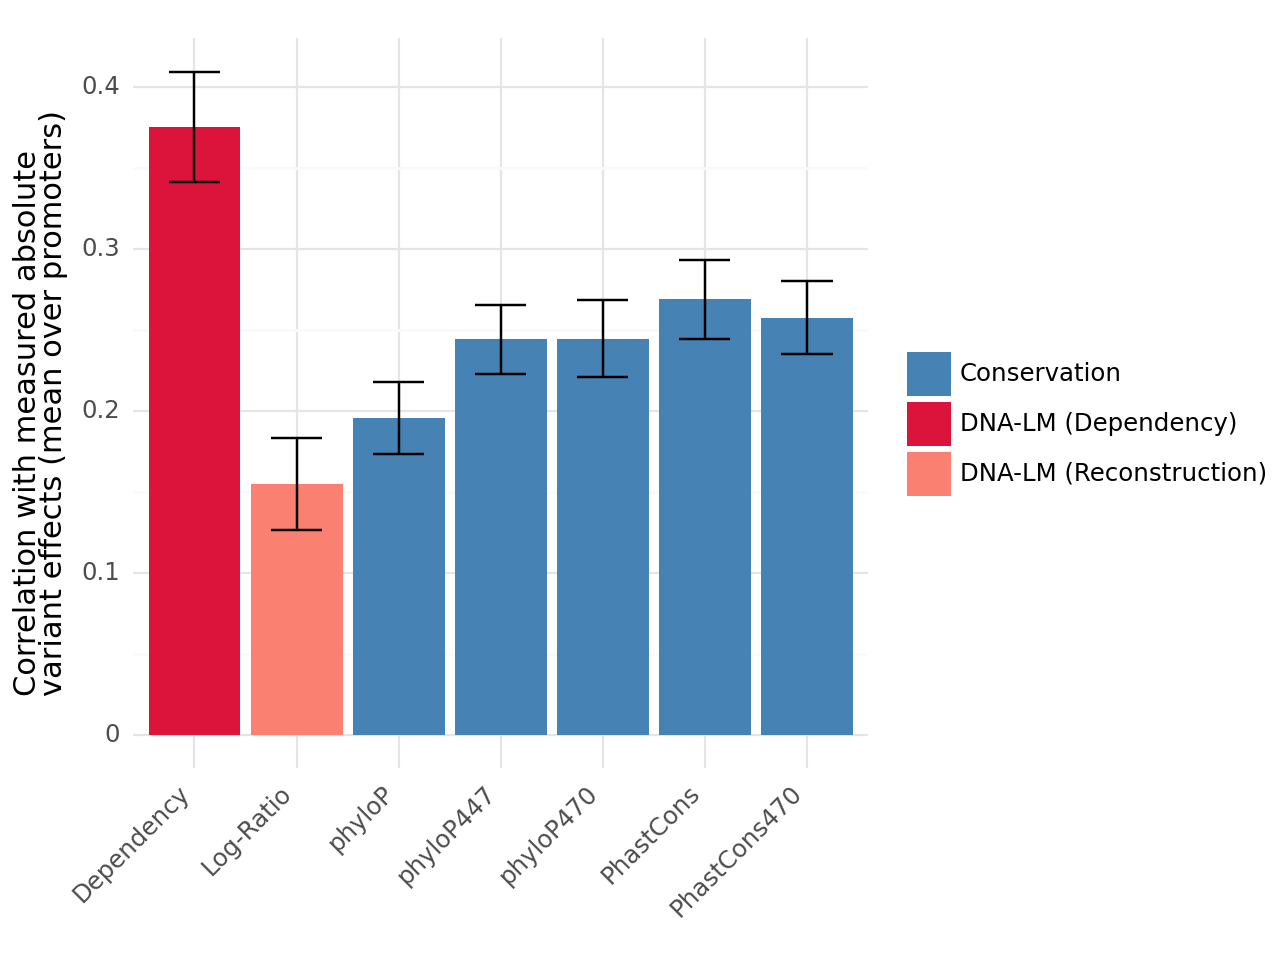

<Figure Size: (640 x 480)>

In [44]:
model_type_dict = {
    "Dependency":"DNA-LM (Dependency)",
    "Log-Ratio":"DNA-LM (Reconstruction)",
    "phyloP":"Conservation",
    "phyloP447":"Conservation",
    "phyloP470":"Conservation",
    "PhastCons":"Conservation",
    "PhastCons470":"Conservation",
}

plot_df = metrics_df_bootstrap_agg.copy()#var_metrics_agg.query('index == "mean"').melt(id_vars="index").query('variable in @model_type_dict')

#plot_df = plot_df.query('variable != "phyloP447"')

plot_df["model_type"] = plot_df["model"].apply(lambda x: model_type_dict[x])
plot_df["model"] = pd.Categorical(plot_df["model"],categories=model_type_dict.keys())


p = (p9.ggplot(data=plot_df, mapping=p9.aes(x="model",y="r", fill="model_type")) 
 #+ p9.geom_boxplot(outlier_shape="") 
 + p9.geom_bar(stat="identity")
 + p9.geom_errorbar(mapping=p9.aes(x="model", ymin="r_min",ymax="r_max"))
 #+ p9.geom_violin() 
 #+ p9.geom_jitter(width=0.25, size=2)
 + p9.scale_fill_manual(["steelblue","crimson","salmon"])
 #+ p9.scale_alpha_manual([0.5,1])
 + p9.labs(x="",y="Correlation with measured absolute\nvariant effects (mean over promoters)", fill="")
 + p9.theme_minimal()
 + p9.theme(
     axis_text_x=p9.element_text(rotation=45, hjust=1),
 )
)

#p.save("IntroFig_Kircher.png", width=6, height=4, dpi=300)

p

## Compare Nucleotide Transformer models

In [45]:
col_mapping_kircher = {"ntv2":"NTv2", 
                       "nt2B":"NT",
                       "nt2B1000G":"NT-Human1000G-2.5B", 
                       "nt1000G":"NT-Human1000G", 
                       "ntHuman":"NT-HumanRef"}

In [46]:
rows = []
for sample_ix in tqdm.tqdm(range(100+1)):
    for i, locus in enumerate(var_metrics["locus"]):
        prom_df = prom_df_reindexed.query('locus == "{}"'.format(locus))
        # collect variant info
        prom_df = prom_df.loc[np.abs(prom_df["log2FC"]) > 0]
    
        # subsample
        if sample_ix > 0:
            prom_df = prom_df.sample(frac=1, replace=True)
        var_eff = np.abs(prom_df["log2FC"])
    
        for column in col_mapping_kircher:
            r = scipy.stats.pearsonr(np.array(prom_df[column]),var_eff)[0]
            rows.append({"sample_ix":sample_ix, "locus":locus, "model":col_mapping_kircher[column],"r":r})

100%|██████████| 101/101 [00:04<00:00, 21.65it/s]


In [47]:
nt_metrics_df_bootstrap = pd.DataFrame(rows) 

In [48]:
nt_metrics_df_bootstrap_agg = nt_metrics_df_bootstrap.groupby(['sample_ix','model'])['r'].mean().reset_index().query('sample_ix == 0').drop(columns="sample_ix")

In [49]:
nt_metrics_df_bootstrap_agg = nt_metrics_df_bootstrap_agg.merge(nt_metrics_df_bootstrap
                                                          .groupby(['sample_ix','model'])['r']
                                                          .mean().reset_index()
                                                          .query('sample_ix > 0')
                                                          .groupby('model')['r'].std()
                                                          .reset_index().rename(columns={"r":"std"}),
                                                         on="model")

In [50]:
nt_metrics_df_bootstrap_agg["r_max"] = nt_metrics_df_bootstrap_agg["r"] + 2*nt_metrics_df_bootstrap_agg["std"]
nt_metrics_df_bootstrap_agg["r_min"] = nt_metrics_df_bootstrap_agg["r"] - 2*nt_metrics_df_bootstrap_agg["std"]

In [51]:
nt_metrics_df_bootstrap_agg

,model,r,std,r_max,r_min
0,NT,0.133748,0.012001,0.157751,0.109746
1,NT-Human1000G,0.026994,0.010868,0.048731,0.005257
2,NT-Human1000G-2.5B,0.076907,0.011309,0.099526,0.054288
3,NT-HumanRef,0.045768,0.010136,0.066040,0.025497
4,NTv2,0.177830,0.015317,0.208464,0.147196


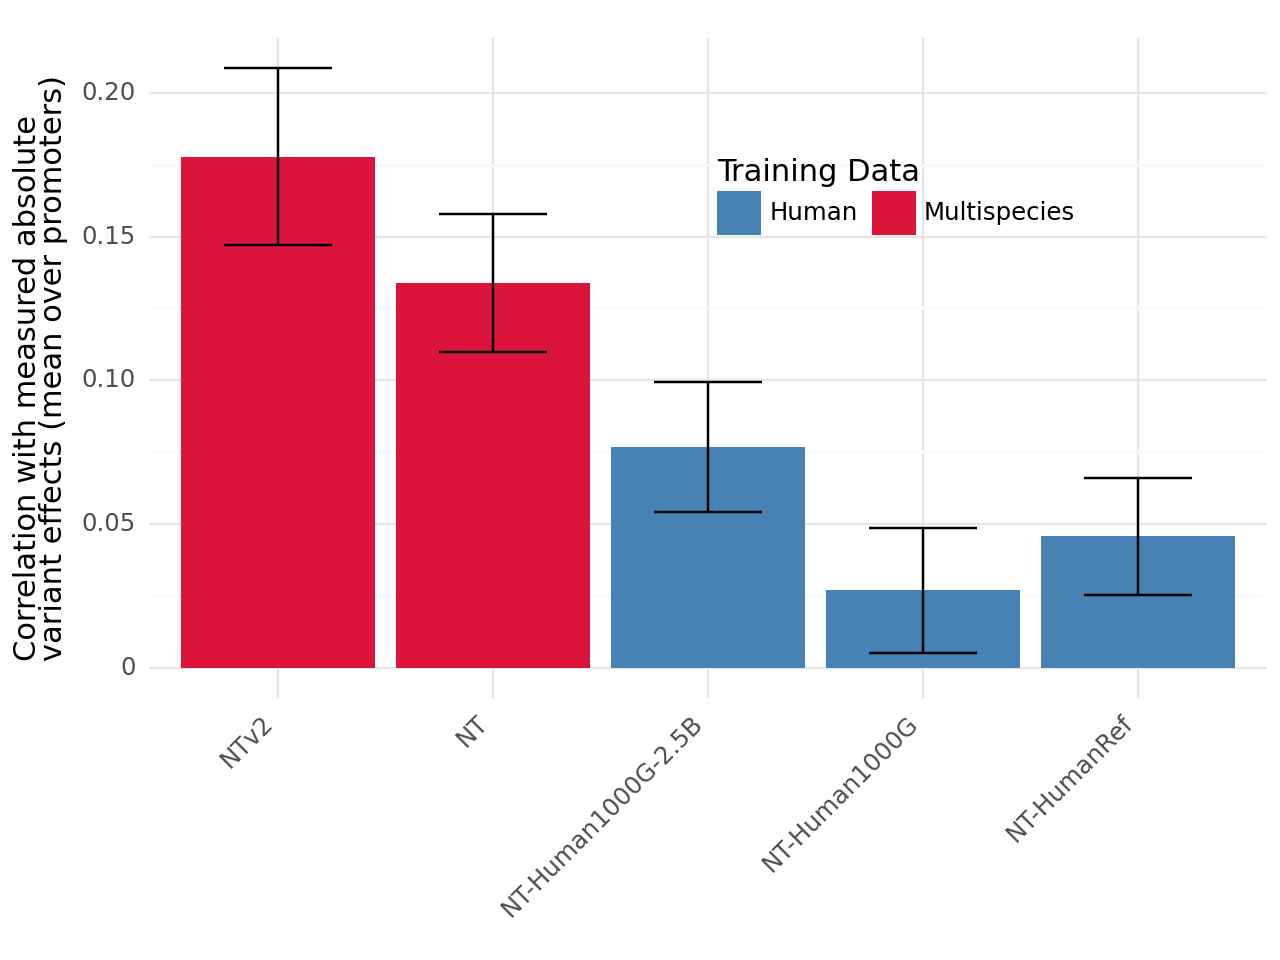

<Figure Size: (640 x 480)>

In [52]:
model_type_dict = {
    "NTv2":"Multispecies",
    "NT":"Multispecies",
    "NT-Human1000G-2.5B":"Human",
    "NT-Human1000G":"Human",
    "NT-HumanRef":"Human",
}

plot_df = nt_metrics_df_bootstrap_agg.copy()#var_metrics_agg.query('index == "mean"').melt(id_vars="index").query('variable in @model_type_dict')

#plot_df = plot_df.query('variable != "phyloP447"')

plot_df["model_type"] = plot_df["model"].apply(lambda x: model_type_dict[x])
plot_df["model"] = pd.Categorical(plot_df["model"],categories=model_type_dict.keys())


p = (p9.ggplot(data=plot_df, mapping=p9.aes(x="model",y="r", fill="model_type")) 
 #+ p9.geom_boxplot(outlier_shape="") 
 + p9.geom_bar(stat="identity")
 + p9.geom_errorbar(mapping=p9.aes(x="model", ymin="r_min",ymax="r_max"))
 #+ p9.geom_violin() 
 #+ p9.geom_jitter(width=0.25, size=2)
 + p9.scale_fill_manual(["steelblue","crimson","salmon"])
 #+ p9.scale_alpha_manual([0.5,1])
 + p9.labs(x="",y="Correlation with measured absolute\nvariant effects (mean over promoters)", fill="Training Data")
 + p9.theme_minimal()
 + p9.theme(
     axis_text_x=p9.element_text(rotation=45, hjust=1),
     legend_position=(0.7,0.8),
 )
)

#p.save("CompareFig_Kircher" + ".png", width=5.0, height=5, dpi=300)

p

# Human eQTL

## Prepare eQTL data

In [53]:
susie_paths = glob.glob(os.path.join(data_path, "susie_credible_sets/GTEx_ge*.txt.gz"))
susie_df_list = []
for path in susie_paths:
    susie_df = pd.read_csv(path, sep="\t").rename(columns={"molecular_trait_id":"gene_id","variant":"variant_id"})
    susie_df["tissue"] = path.split("/")[-1].split('.')[0][8:]
    susie_df_list.append(susie_df)
susie_df = pd.concat(susie_df_list)
susie_df = susie_df.loc[(susie_df.alt.str.len() == 1) & (susie_df.ref.str.len() == 1)] # reduce to SNP
susie_df["causal"] = susie_df["pip"] > 0.9
# swtich to zero-based
susie_df["Start"] = susie_df["position"] - 1
susie_df["End"] = susie_df["position"]
susie_df["Chromosome"] = susie_df["chromosome"]
# extract causal variants
causal_df = susie_df.query('causal')
causal_pr = pr.PyRanges(causal_df[["Chromosome","Start","End", "ref", "alt", "pip", "variant_id", "finemapped_region", "tissue" , "causal"]])
dataset_pr = pr.PyRanges(dataset[["Chromosome", "five_prime_start", "five_prime_end", "gene_id", "transcript_id", "Strand", "five_prime_seq"]].rename(columns={"five_prime_start":"Start","five_prime_end":"End"}))
causal_merged = causal_pr.join(dataset_pr).df.rename(columns={"Start_b":"five_prime_start","End_b":"five_prime_end"})
causal_merged["rel_pos"] = causal_merged.apply(lambda x: x["Start"]-x["five_prime_start"] if x["Strand"] == "+" else 2002 -(x["Start"]-x["five_prime_start"]), axis=1)
causal_merged = causal_merged.sort_values(['rel_pos']).drop_duplicates('variant_id', keep="last")
# get negative set for the same genes
noncausal_df = susie_df.query('pip < 0.01')
noncausal_pr = pr.PyRanges(noncausal_df[["Chromosome","Start","End", "ref", "alt", "pip", "variant_id", "finemapped_region", "tissue" , "causal"]])
noncausal_merged = noncausal_pr.join(dataset_pr).df.rename(columns={"Start_b":"five_prime_start","End_b":"five_prime_end"})
noncausal_merged["rel_pos"] = noncausal_merged.apply(lambda x: x["Start"]-x["five_prime_start"] if x["Strand"] == "+" else 2002 -(x["Start"]-x["five_prime_start"]), axis=1)
noncausal_merged = noncausal_merged.loc[noncausal_merged["transcript_id"].isin(set(causal_merged["transcript_id"]))]
noncausal_merged = noncausal_merged.loc[~noncausal_merged["variant_id"].isin(set(causal_merged["variant_id"]))]
noncausal_merged = noncausal_merged.sort_values(['rel_pos']).drop_duplicates('variant_id', keep="last")
# combine
susie_merged = pd.concat([causal_merged,noncausal_merged],axis=0).reset_index(drop=True)
# get genes
susie_merged[["Chromosome", "five_prime_start", "five_prime_end", "gene_id", "transcript_id", "Strand",  "five_prime_seq"]].drop_duplicates().reset_index(drop=True).to_parquet(os.path.join(data_path, "susie_eqtl_genes.parquet"))
susie_merged.to_parquet(os.path.join(data_path , "susie_eqtl.parquet"))

/scratch/tmp/tomazdas/ipykernel_2483264/231093249.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
/scratch/tmp/tomazdas/ipykernel_2483264/231093249.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
/scratch/tmp/tomazdas/ipykernel_2483264/231093249.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
/scratch/tmp/tomazdas/ipykernel_2483264/231093249.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
/scratch/tmp/tomazdas/ipykernel_2483264/231093249.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
/scratch/tmp/tomazdas/ipykernel_2483264/231093249.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
/scratch/tmp/tomazdas/ipykernel_2483264/231093249.py:4: DtypeWar

## Get conservation tracks

In [55]:
susie_merged["PhastCons"] = torch.load(os.path.join(data_path, 'conservation_human_eqtl_phastcons/prbs_tensor.pt')).flatten().nan_to_num(0)
susie_merged["PhyloP"] = torch.load(os.path.join(data_path, 'conservation_human_eqtl_phyloP/prbs_tensor.pt')).flatten().nan_to_num(0)
susie_merged["PhastCons470"] = torch.load(os.path.join(data_path, 'conservation_human_eqtl_phastcons470/prbs_tensor.pt')).flatten().nan_to_num(0)
susie_merged["PhyloP470"] = torch.load(os.path.join(data_path, 'conservation_human_eqtl_phyloP470/prbs_tensor.pt')).flatten().nan_to_num(0)
susie_merged["PhyloP447"] = torch.load(os.path.join(data_path,'conservation_human_eqtl_phyloP447/prbs_tensor.pt')).flatten().nan_to_num(0)

## Annotate with Log-Ratio

In [56]:
susie_merged["Log-Ratio"] = -torch.load(os.path.join(data_path, "human_eqtl_nucpreds.pt"))

## Annotate with rowsums

dataset = pd.read_parquet(os.path.join(data_path,"susie_eqtl_genes.parquet"))
dataset = dataset.reset_index(drop=True).reset_index()

snp_df = pd.read_parquet(os.path.join(data_path,"samples_upstream_metazoa_eqtlprom_interaction/homo_sapiens/snp.parquet")).reset_index()
id_to_path = pd.read_parquet(os.path.join(data_path,"samples_upstream_metazoa_eqtlprom_interaction/homo_sapiens/id_to_path.parquet"))
snp_df = id_to_path.merge(snp_df, on="transcript_id")

In [58]:
susie_merged = susie_merged.merge(dataset[["gene_id","transcript_id","index"]], on=["gene_id","transcript_id"])

In [59]:
rowsums = torch.load(os.path.join(data_path,'rowsums.pytorch'))

In [60]:
nuc_to_number = {"A":0,"C":1,"G":2,"T":3}
nuc_to_revcomp = {"A":"T","T":"A","G":"C","C":"G"}

ref_nucs = []
alt_nucs = []
indices = []
positions = []
for _,var_row in susie_merged.iterrows():
    strand = var_row["Strand"]
    ref = var_row["ref"] if strand == "+" else nuc_to_revcomp[var_row["ref"]]
    alt = var_row["alt"] if strand == "+" else nuc_to_revcomp[var_row["alt"]]
    assert ref != alt
    assert ref == var_row["five_prime_seq"][var_row["rel_pos"]], var_row["Variant"]
    abs_pos = var_row["rel_pos"]
    ref_nucs.append(nuc_to_number[ref])
    alt_nucs.append(nuc_to_number[alt])
    positions.append(abs_pos)
    indices.append(var_row["index"])

In [61]:
# extract row-sum
var_rowsums = rowsums
# select matching positions
var_rowsums = rowsums[torch.tensor(indices),torch.tensor(positions)]
var_rowsums = (torch.nn.functional.one_hot(torch.tensor(alt_nucs),num_classes=4)*var_rowsums).amax(axis=1)
susie_merged["Interaction"] = var_rowsums

## Plot

In [62]:
susie_merged

,Chromosome,Start,End,ref,alt,pip,variant_id,finemapped_region,tissue,causal,...,five_prime_seq,rel_pos,PhastCons,PhyloP,PhastCons470,PhyloP470,PhyloP447,Log-Ratio,index,Interaction
0,14,21036287,21036288,A,G,0.995505,chr14_21036288_A_G,chr14:20042316-22042316,testis,True,...,TCACACTTTTTCTCTTGAAGTTGTATAAGAGATATATTTGAGTTGA...,0,0.000,-0.090,0.000,-0.432,-0.215,0.000478,0,0.027788
1,16,20409484,20409485,G,T,0.999682,chr16_20409485_G_T,chr16:19409534-21409534,thyroid,True,...,GGAAGCCACTGTGTCAGCTGCTGGGTTCTGGCTCTGCCCACTCTTG...,0,0.009,0.366,0.000,-1.106,-2.450,0.902197,1,0.032828
2,16,20409998,20409999,G,A,0.005957,chr16_20409999_G_A,chr16:19409534-21409534,adipose_subcutaneous,False,...,GGAAGCCACTGTGTCAGCTGCTGGGTTCTGGCTCTGCCCACTCTTG...,514,0.000,-0.392,0.000,-2.082,-1.286,-0.030431,1,0.033228
3,16,20411362,20411363,A,G,0.007939,chr16_20411363_A_G,chr16:19447000-21447000,liver,False,...,GGAAGCCACTGTGTCAGCTGCTGGGTTCTGGCTCTGCCCACTCTTG...,1878,0.000,-1.720,0.000,-3.980,-3.741,0.028856,1,0.033647
4,1,19310499,19310500,C,G,0.999985,chr1_19310500_C_G,chr1:18312146-20312146,esophagus_mucosa,True,...,GGCTGGTCTTCAACTCCTGACCTCAAGTGATCTGCCCACCTCAGCC...,5,0.000,-0.999,0.004,-1.104,0.433,6.433924,2,0.034924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2953,19,9324195,9324196,C,T,0.917974,chr19_9324196_C_T,chr19:8323772-10323772,brain_cortex,True,...,ACCAATCAACACTCTGTATCTAGCTACTCTGGTGGGGACTTGGAGA...,1999,0.005,0.143,0.001,0.979,0.141,0.881371,1427,0.044576
2954,19,9322203,9322204,A,G,0.003631,chr19_9322204_A_G,chr19:8323772-10323772,brain_anterior_cingulate_cortex,False,...,ACCAATCAACACTCTGTATCTAGCTACTCTGGTGGGGACTTGGAGA...,7,0.000,0.000,0.016,-3.449,-3.219,0.658038,1427,0.057012
2955,19,9322435,9322436,G,T,0.001770,chr19_9322436_G_T,chr19:8621236-10621236,fibroblast,False,...,ACCAATCAACACTCTGTATCTAGCTACTCTGGTGGGGACTTGGAGA...,239,0.000,0.000,0.003,0.143,0.138,4.050880,1427,0.055995
2956,16,57058064,57058065,T,C,0.972072,chr16_57058065_T_C,chr16:56058497-58058497,LCL,True,...,TACTAGTATTGTTCTCATTTTACAGATGAGGGAACTGAGACACAGA...,2000,1.000,0.424,1.000,2.652,3.628,-2.400690,1428,0.035227


In [63]:
susie_merged["causal_str"] = susie_merged["causal"].apply(lambda x: "Causal (PIP > 0.9)" if x else "Noncausal (PIP < 0.01)")

susie_merged["causal_str"] = pd.Categorical(susie_merged["causal_str"], categories=["Noncausal (PIP < 0.01)","Causal (PIP > 0.9)"])

In [64]:
len(susie_merged)

2958

In [65]:
len(susie_merged.query('causal'))

1631

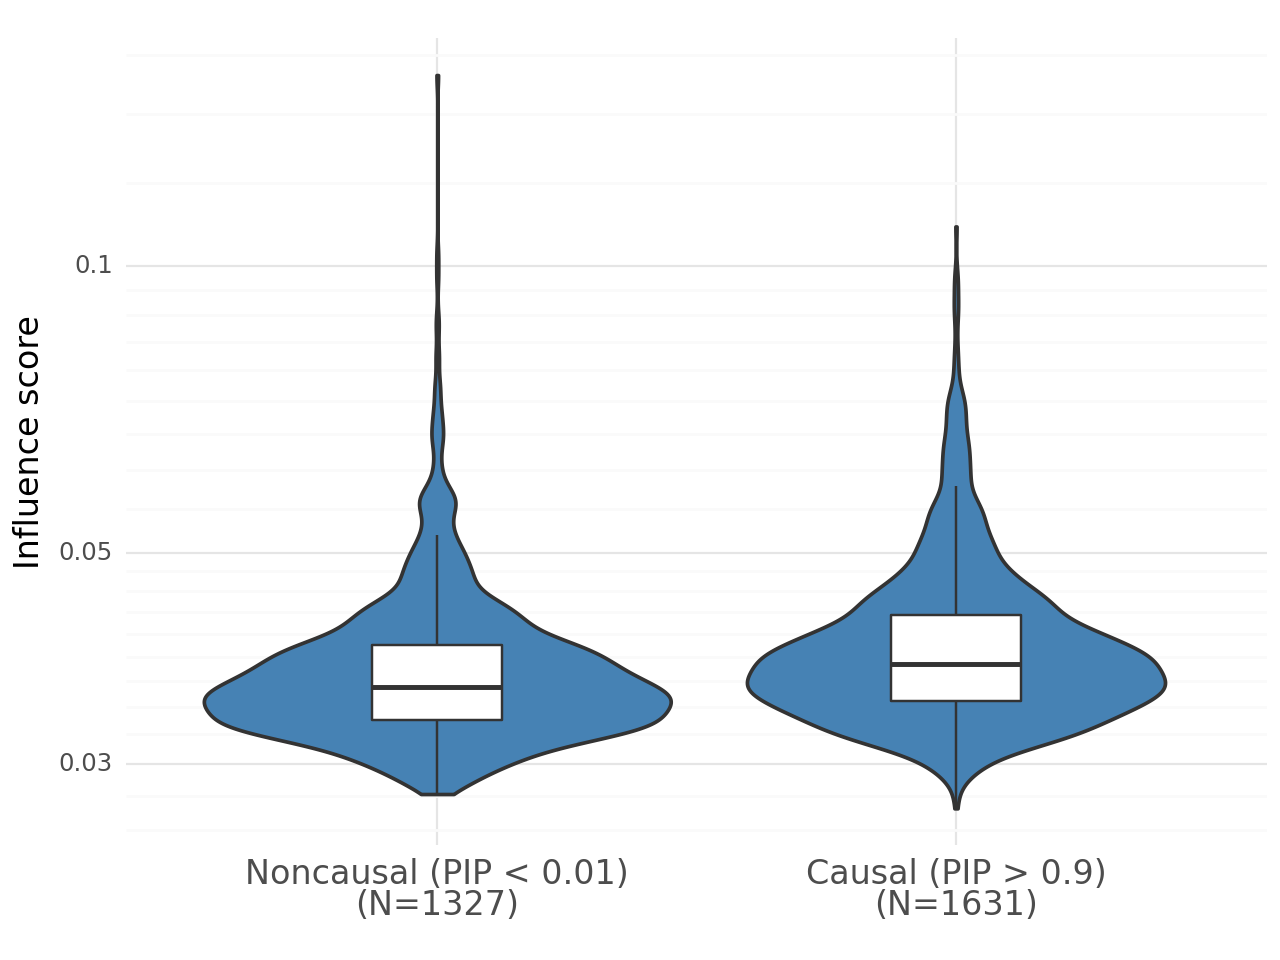

<Figure Size: (640 x 480)>

In [66]:
counts = susie_merged['causal_str'].value_counts()

susie_merged['causal_str_label'] = susie_merged['causal_str'].map(lambda x: f"{x}\n(N={counts[x]})")

p = (p9.ggplot(data=susie_merged, mapping=p9.aes(x="causal_str_label",y="Interaction")) 
 + p9.geom_violin(size=0.75, fill="steelblue")#, draw_quantiles=[0.25,0.5,0.75])
 + p9.geom_boxplot(width=0.25, outlier_shape="")
 #+ p9.geom_jitter(alpha=0.001)
 #+ p9.geom_violin(fill="blue", size=0.75)
 + p9.labs(x="",y="Influence score", color="")
 + p9.scale_y_log10()
 #+ p9.scale_alpha(guide=False)
 + p9.theme_minimal()
 + p9.theme(legend_text = p9.element_text(size=12),
        legend_key_size=12,
        legend_background=p9.element_blank(),
        legend_title=p9.element_text(size=12),
        axis_text_x = p9.element_text(size=12),
        legend_position=(0.8,0.3), 
        legend_direction='vertical',
        axis_title=p9.element_text(size=12),
       )
    )


#p.save("SupFigIntro_HumanEqtl_violin" + ".png", width=6, height=4, dpi=300)

p

In [67]:
scipy.stats.mannwhitneyu(susie_merged.query('causal')["Interaction"],susie_merged.query('not causal')["Interaction"])

MannwhitneyuResult(statistic=1310633.0, pvalue=4.624216912918919e-23)

In [68]:
scipy.stats.ranksums(susie_merged.query('causal')["Interaction"],susie_merged.query('not causal')["Interaction"])

RanksumsResult(statistic=9.889502058739437, pvalue=4.623217319733063e-23)

## Measure Performance

In [69]:
pred_types = {"PhyloP":"PhyloP",
              "PhastCons":"PhastCons",
              "PhyloP470":"PhyloP470",
              "PhyloP447":"PhyloP447",
              "PhastCons470":"PhastCons470",
              "Log-Ratio":"Log-Ratio", # Reconstruction (CE)
              "Interaction":"Interaction",
             }

roc_plot_df_list = []
roc_auc_dict = {}
roc_df = susie_merged.copy()
labels = susie_merged["causal"]

for pred_type in pred_types:
    fpr, tpr, thresholds = roc_curve(y_true=np.array(labels), y_score=np.array(susie_merged[pred_type]))
    roc_auc = roc_auc_score(y_true=np.array(labels), y_score=np.array(susie_merged[pred_type]))
    roc_auc_dict[pred_types[pred_type]] = roc_auc
    roc_plot_df_list.append(pd.DataFrame({"fpr":fpr,"tpr":tpr,"roc_auc":roc_auc,"Type":pred_types[pred_type]}))
roc_plot_df = pd.concat(roc_plot_df_list)

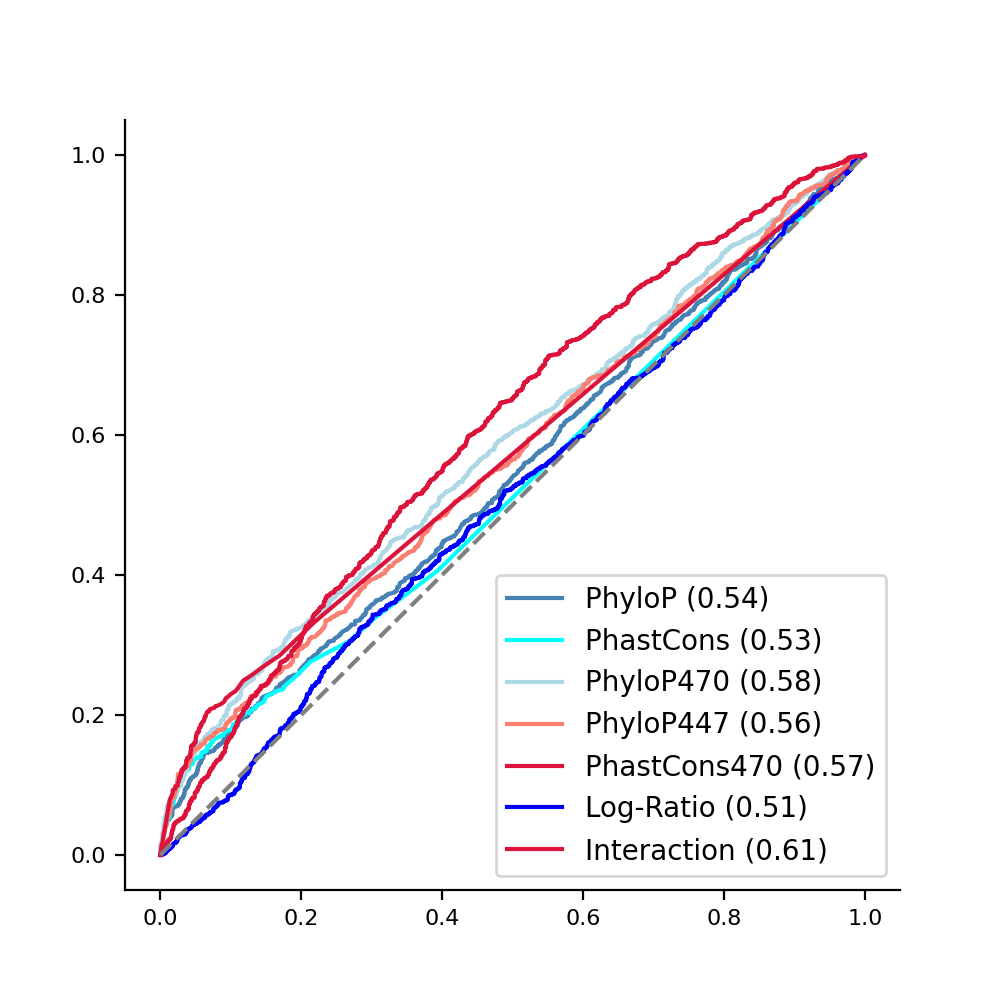

In [70]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
colors = ["steelblue","cyan","lightblue","salmon","crimson","blue","crimson"]#["steelblue","lightblue","darkgreen","blue","crimson","yellow"]#["yellow","purple","green","black","blue","pink"]

for i,pred_type in enumerate(pred_types.values()):
    roc_plot_df_sub = roc_plot_df.query('Type == @pred_type')
    ax.plot(roc_plot_df_sub["fpr"],roc_plot_df_sub["tpr"], color=colors[i], label="{} ({:2.2f})".format(pred_type,roc_plot_df_sub["roc_auc"].iloc[0]))
    #ax.plot(roc_dict[model]["rec"],roc_dict[model]["prec"], color=color, label="AUPRC = {:2.2f} {}".format(roc_dict[model]["auprc"], model))
# add diagonal
ax.plot([0,1],[0,1], color='grey', linestyle='dashed')
ax.legend(loc=4)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=8)
plt.show()

In [71]:
plot_rocs = pd.DataFrame(roc_auc_dict,index=[0]).rename(columns={"Interaction":"Dependency"}).melt()

In [72]:
plot_rocs

,variable,value
0,PhyloP,0.540702
1,PhastCons,0.525363
2,PhyloP470,0.581670
3,PhyloP447,0.564026
4,PhastCons470,0.568986
5,Log-Ratio,0.509666
6,Dependency,0.605559


In [73]:
rocs_samples = []
for i in tqdm.tqdm(range(100)):
    roc_df = susie_merged.copy()
    roc_df = roc_df.sample(frac=1, replace=True)
    labels = roc_df["causal"]
    
    for pred_type in pred_types:
        roc_auc = roc_auc_score(y_true=np.array(labels), y_score=np.array(roc_df[pred_type]))
        roc_auc_dict[pred_types[pred_type]] = roc_auc
    
    rocs_samples.append(pd.DataFrame(roc_auc_dict,index=[0]).rename(columns={"Interaction":"Dependency"}).melt())

100%|██████████| 100/100 [00:01<00:00, 87.31it/s]


In [74]:
rocs_sample = pd.concat(rocs_samples)

In [75]:
plot_rocs = plot_rocs.merge(rocs_sample.groupby('variable')['value'].std().reset_index().rename(columns={"value":"std"}), on="variable")

In [76]:
plot_rocs["auroc_max"] = plot_rocs["value"] + 2*plot_rocs["std"]
plot_rocs["auroc_min"] = plot_rocs["value"] - 2*plot_rocs["std"]

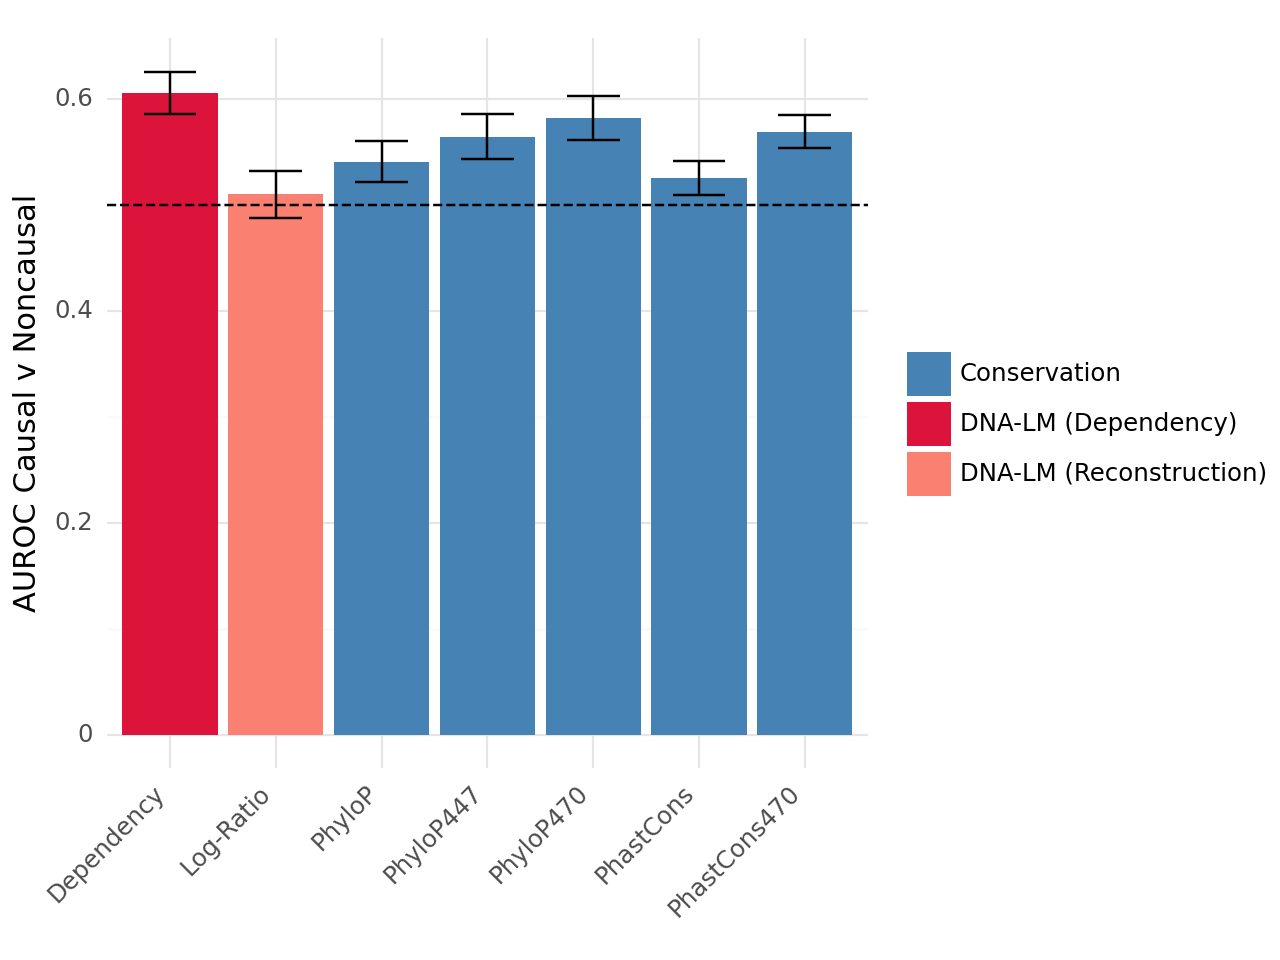

<Figure Size: (640 x 480)>

In [77]:
model_type_dict = {
    "Dependency":"DNA-LM (Dependency)",
    "Log-Ratio":"DNA-LM (Reconstruction)",
    "PhyloP":"Conservation",
    "PhyloP447":"Conservation",
    "PhyloP470":"Conservation",
    "PhastCons":"Conservation",
    "PhastCons470":"Conservation",
}

plot_df = plot_rocs#pd.DataFrame(roc_auc_dict,index=[0]).rename(columns={"Interaction":"Dependency"}).melt()

#plot_df = plot_df.query('variable != "phyloP447"')

plot_df["model_type"] = plot_df["variable"].apply(lambda x: model_type_dict[x])
plot_df["variable"] = pd.Categorical(plot_df["variable"],categories=model_type_dict.keys())


p = (p9.ggplot(data=plot_df, mapping=p9.aes(x="variable",y="value", fill="model_type")) 
 #+ p9.geom_point() 
 + p9.geom_bar(stat="identity")
 + p9.geom_errorbar(mapping=p9.aes(x="variable", ymin="auroc_min",ymax="auroc_max"))
 + p9.geom_hline(yintercept=0.5, linetype="dashed")
 #+ p9.coord_cartesian(ylim=(0.5,1))
 #+ p9.geom_violin() 
 #+ p9.geom_jitter(width=0.25, size=2)
 + p9.scale_fill_manual(["steelblue","crimson","salmon"])
 #+ p9.scale_alpha_manual([0.5,1])
 + p9.labs(x="",y="AUROC Causal v Noncausal", fill="")
 + p9.theme_minimal()
 + p9.theme(
     axis_text_x=p9.element_text(rotation=45, hjust=1),
 )
)

#p.save("SupFigIntro_HumanEqtl_bar" + ".png", width=6, height=4, dpi=300)

p

# Clinvar

In [78]:
clinvar_df = pd.read_table(os.path.join(data_path,'clinvar_pathogenic_benign_w_likely_w_seq_and_ALT_w_pos_w_row_means.tsv'))

/scratch/tmp/tomazdas/ipykernel_2483264/912026080.py:1: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.


## Annotate with more conservation scores

In [79]:
clinvar_df["phylop470"] = torch.load(os.path.join(data_path, "conservation_human_clinvar_phyloP470/prbs_tensor.pt")).flatten().nan_to_num(0)
clinvar_df["phylop447"] = torch.load(os.path.join(data_path, "conservation_human_clinvar_phyloP447/prbs_tensor.pt")).flatten().nan_to_num(0)
clinvar_df["phastcons"] = torch.load(os.path.join(data_path,"conservation_human_clinvar_phastcons/prbs_tensor.pt")).flatten().nan_to_num(0)
clinvar_df["phastcons470"] = torch.load(os.path.join(data_path, "conservation_human_clinvar_phastcons470/prbs_tensor.pt")).flatten().nan_to_num(0)

## Annotate with nucpreds

In [80]:
clinvar_df

,index,Chromosome,Start,ID,REF,ALT,QUAL,FILTER,CLNSIG,CLNDN,...,alt_nuc_seq,seq_ALT_len,CHROM,POS,row_mean,phylop,phylop470,phylop447,phastcons,phastcons470
0,0,chr1,68132,2205837,A,G,NaN,NaN,Likely_benign,"('Inborn_genetic_diseases',)",...,G,2003,1,69134,0.017212,0.405,0.324,1.932,0.000,0.000
1,1,chr1,924954,1543320,C,T,NaN,NaN,Likely_benign,"('not_provided',)",...,T,2003,1,925956,0.039483,1.393,-0.585,-0.403,1.000,0.031
2,2,chr1,924967,1648427,C,T,NaN,NaN,Likely_benign,"('not_provided',)",...,T,2003,1,925969,0.023424,5.538,7.453,7.858,1.000,1.000
3,3,chr1,924978,1936488,C,T,NaN,NaN,Likely_benign,"('not_provided',)",...,T,2003,1,925980,0.035762,-0.202,0.990,1.529,0.740,1.000
4,4,chr1,924984,1568423,C,T,NaN,NaN,Likely_benign,"('not_provided',)",...,T,2003,1,925986,0.018852,-0.067,-0.693,-0.221,0.859,0.034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
838843,838843,chrY,2786433,664404,G,A,NaN,NaN,Pathogenic,"('46', 'XY_sex_reversal_1')",...,A,2003,Y,2787435,0.092188,4.058,2.114,0.729,1.000,0.019
838844,838844,chrY,9466025,769492,C,T,NaN,NaN,Likely_benign,"('not_provided',)",...,T,2003,Y,9467027,0.039716,0.224,-0.183,0.067,0.005,0.000
838845,838845,chrY,12811932,1269192,C,T,NaN,NaN,Benign,"('not_provided',)",...,T,2003,Y,12812934,0.014577,0.907,-2.201,-15.654,1.000,0.000
838846,838846,chrY,14823199,777318,C,T,NaN,NaN,Benign,"('not_provided',)",...,T,2003,Y,14824201,0.025458,-0.652,-20.000,-7.693,0.342,0.000


In [81]:
prbs = torch.load(os.path.join(data_path, "clinvar_nucpreds.pt"))

In [82]:
nuc_to_number = {"A":0,"C":1,"G":2,"T":3,"N":0}
nuc_to_revcomp = {"A":"T","T":"A","G":"C","C":"G"}

ref_nucs = []
alt_nucs = []

for _,var_row in tqdm.tqdm(clinvar_df.iterrows()):
    ref = var_row["REF"] 
    alt = var_row["ALT"] 
    ref_nucs.append(nuc_to_number[ref])
    alt_nucs.append(nuc_to_number[alt])

838848it [00:28, 29041.53it/s]


In [83]:
# compute metrics
ref_prbs = (torch.nn.functional.one_hot(torch.tensor(ref_nucs),num_classes=4)*prbs).max(axis=1)[0]
alt_prbs = (torch.nn.functional.one_hot(torch.tensor(alt_nucs),num_classes=4)*prbs).max(axis=1)[0]
# var eff as log ratio
var_eff = np.log2(alt_prbs/ref_prbs)

In [84]:
clinvar_df["Log-Ratio"] = -var_eff

## Analyse noncoding

In [85]:
non_coding_info = ['intron_variant', '5_prime_UTR_variant', 'splice_acceptor_variant', 'splice_donor_variant', '3_prime_UTR_variant', 
    'non-coding_transcript_variant', 'genic_upstream_transcript_variant', 'genic_downstream_transcript_variant']

In [86]:
clinvar_df_noncoding = clinvar_df.query('MC_info in @non_coding_info')

In [87]:
len(clinvar_df_noncoding)

385572

In [88]:
np.sum(clinvar_df_noncoding["CLNSIG_simple"] == "Pathogenic")

22313

/scratch/tmp/tomazdas/ipykernel_2483264/1156764074.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


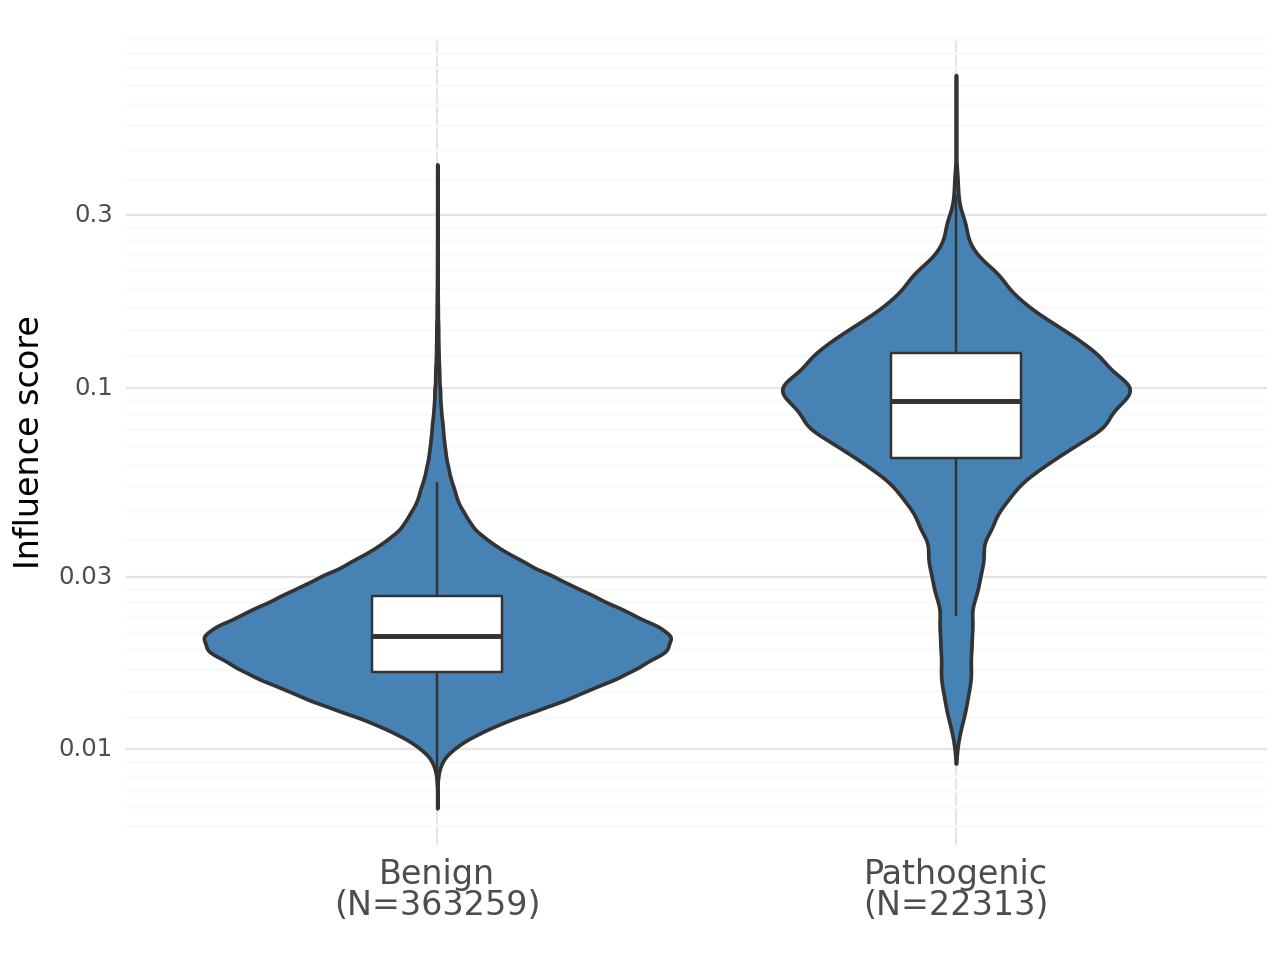

<Figure Size: (640 x 480)>

In [89]:
#calculate counts for each category in CLNSIG_simple
counts = clinvar_df_noncoding['CLNSIG_simple'].value_counts()

clinvar_df_noncoding['CLNSIG_label'] = clinvar_df_noncoding['CLNSIG_simple'].map(lambda x: f"{x}\n(N={counts[x]})")

p = (p9.ggplot(data=clinvar_df_noncoding, mapping=p9.aes(x="CLNSIG_label",y="row_mean")) 
 + p9.geom_violin(size=0.75, fill="steelblue")#, draw_quantiles=[0.25,0.5,0.75])
 + p9.geom_boxplot(width=0.25, outlier_shape="")
 #+ p9.geom_jitter(alpha=0.001)
 #+ p9.geom_violin(fill="blue", size=0.75)
 + p9.labs(x="",y="Influence score", color="")
 + p9.scale_y_log10()
 #+ p9.scale_alpha(guide=False)
 + p9.theme_minimal()
 + p9.theme(legend_text = p9.element_text(size=12),
        legend_key_size=12,
        legend_background=p9.element_blank(),
        legend_title=p9.element_text(size=12),
        axis_text_x = p9.element_text(size=12),
        legend_position=(0.8,0.3), 
        legend_direction='vertical',
        axis_title=p9.element_text(size=12),
       )
    )


#p.save("IntroFig_Clinvar_violin" + ".png", width=6, height=4, dpi=300)

p

In [90]:
from scipy.stats import ranksums

array([0.04469669, 0.02352492, 0.02168851, ..., 0.01469013, 0.02513144,
       0.01841497])

In [91]:
ranksums(clinvar_df_noncoding[clinvar_df_noncoding['CLNSIG_simple']=='Benign'].row_mean.values, clinvar_df_noncoding[clinvar_df_noncoding['CLNSIG_simple']=='Pathogenic'].row_mean.values)

RanksumsResult(statistic=-225.10168328557697, pvalue=0.0)

In [92]:
scipy.stats.mannwhitneyu(clinvar_df_noncoding.query('CLNSIG_simple == "Pathogenic"')["row_mean"],clinvar_df_noncoding.query('CLNSIG_simple != "Pathogenic"')["row_mean"])

MannwhitneyuResult(statistic=7685391231.0, pvalue=0.0)

In [93]:
pred_types = {"phylop":"PhyloP",
              "phastcons":"PhastCons",
              "phylop470":"PhyloP470",
              "phylop447":"PhyloP447",
              "phastcons470":"PhastCons470",
              "Log-Ratio":"Log-Ratio", # Reconstruction (CE)
              "row_mean":"Dependency",
             }

roc_plot_df_list = []
roc_auc_dict = {}
roc_df = clinvar_df_noncoding.copy()
labels = roc_df["CLNSIG_simple"] == "Pathogenic"

for pred_type in pred_types:
    fpr, tpr, thresholds = roc_curve(y_true=np.array(labels), y_score=np.array(roc_df[pred_type]))
    roc_auc = roc_auc_score(y_true=np.array(labels), y_score=np.array(roc_df[pred_type]))
    roc_auc_dict[pred_types[pred_type]] = roc_auc
    roc_plot_df_list.append(pd.DataFrame({"fpr":fpr,"tpr":tpr,"roc_auc":roc_auc,"Type":pred_types[pred_type]}))
roc_plot_df = pd.concat(roc_plot_df_list)

In [94]:
plot_rocs = pd.DataFrame(roc_auc_dict,index=[0]).rename(columns={"Interaction":"Dependency"}).melt()

In [95]:
rocs_samples = []
for i in tqdm.tqdm(range(100)):
    roc_df = clinvar_df_noncoding.copy()
    roc_df = roc_df.sample(frac=1, replace=True)
    labels = roc_df["CLNSIG_simple"] == "Pathogenic"
    
    for pred_type in pred_types:
        roc_auc = roc_auc_score(y_true=np.array(labels), y_score=np.array(roc_df[pred_type]))
        roc_auc_dict[pred_types[pred_type]] = roc_auc
    
    rocs_samples.append(pd.DataFrame(roc_auc_dict,index=[0]).rename(columns={"Interaction":"Dependency"}).melt())

100%|██████████| 100/100 [01:20<00:00,  1.24it/s]


In [96]:
rocs_sample = pd.concat(rocs_samples)

In [97]:
plot_rocs = plot_rocs.merge(rocs_sample.groupby('variable')['value'].std().reset_index().rename(columns={"value":"std"}), on="variable")

In [98]:
plot_rocs["auroc_max"] = plot_rocs["value"] + 2*plot_rocs["std"]
plot_rocs["auroc_min"] = plot_rocs["value"] - 2*plot_rocs["std"]

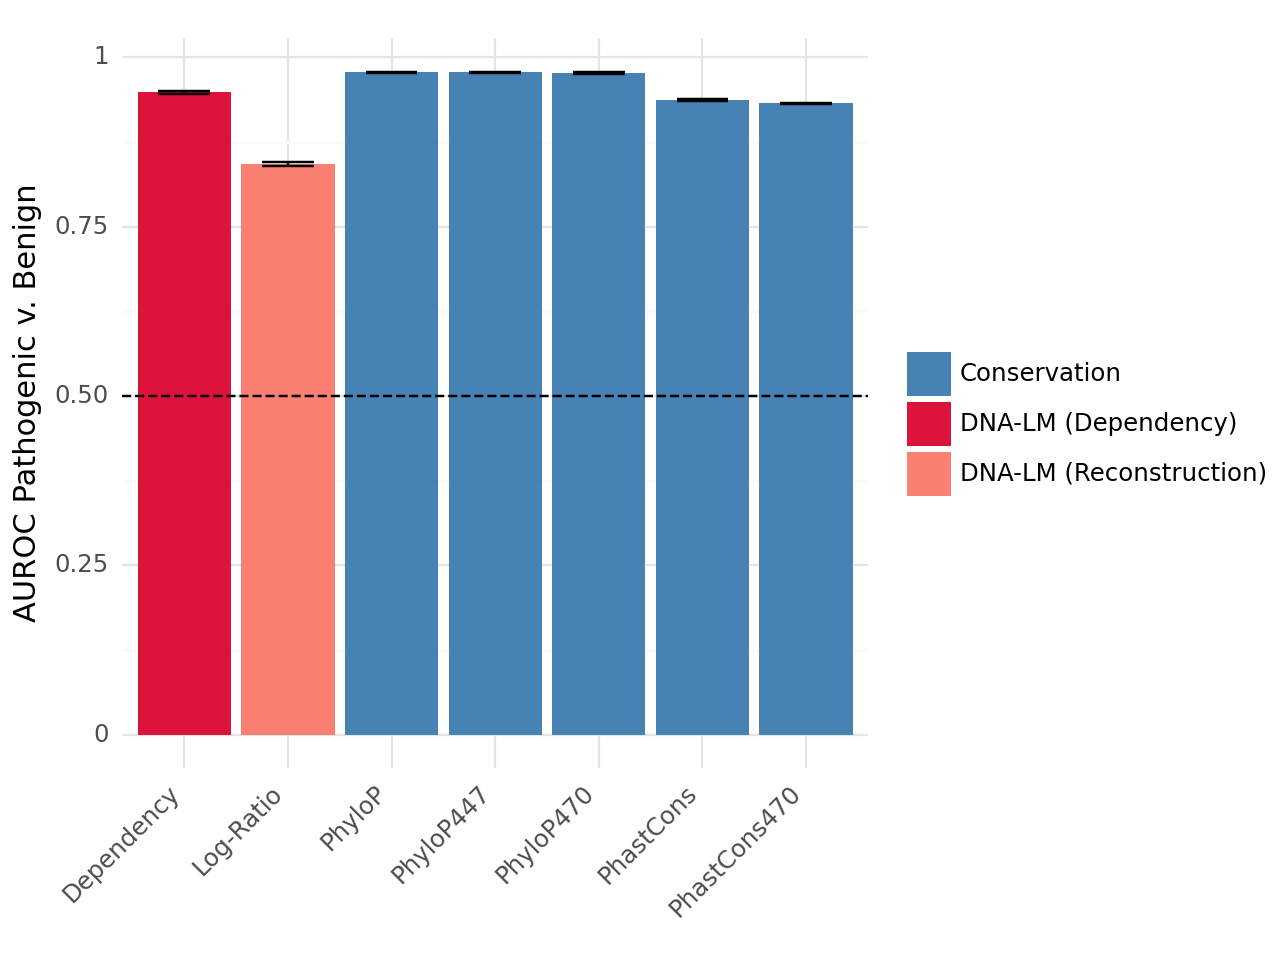

<Figure Size: (640 x 480)>

In [99]:
model_type_dict = {
    "Dependency":"DNA-LM (Dependency)",
    "Log-Ratio":"DNA-LM (Reconstruction)",
    "PhyloP":"Conservation",
    "PhyloP447":"Conservation",
    "PhyloP470":"Conservation",
    "PhastCons":"Conservation",
    "PhastCons470":"Conservation",
}

plot_df = plot_rocs#pd.DataFrame(roc_auc_dict,index=[0]).melt()

#plot_df = plot_df.query('variable != "phyloP447"')

plot_df["model_type"] = plot_df["variable"].apply(lambda x: model_type_dict[x])
plot_df["variable"] = pd.Categorical(plot_df["variable"],categories=model_type_dict.keys())


p = (p9.ggplot(data=plot_df, mapping=p9.aes(x="variable",y="value", fill="model_type")) 
 #+ p9.geom_boxplot(outlier_shape="") 
 + p9.geom_bar(stat="identity")
 + p9.geom_errorbar(mapping=p9.aes(x="variable", ymin="auroc_min",ymax="auroc_max"))
  + p9.geom_hline(yintercept=0.5, linetype="dashed")
 #+ p9.coord_cartesian(ylim=(0.5,1))
 #+ p9.geom_violin() 
 #+ p9.geom_jitter(width=0.25, size=2)
 + p9.scale_fill_manual(["steelblue","crimson","salmon"])
 #+ p9.scale_alpha_manual([0.5,1])
 + p9.labs(x="",y="AUROC Pathogenic v. Benign", fill="")
 + p9.theme_minimal()
 + p9.theme(
     axis_text_x=p9.element_text(rotation=45, hjust=1),
 )
)

#p.save("SupFigIntro_Clinvar_bar" + ".png", width=6, height=4, dpi=300)

p

## Nucleotide Transformer

In [100]:
clinvar_nomito = pd.read_table(os.path.join(data_path, "clinvar_seqs_nomito.tsv"))

In [101]:
clinvar_nomito["nt_index"] = clinvar_nomito.apply(lambda row: nuc_to_number[row["ALT"]] if row["ALT"] != "N" else (0 if row["REF"] != "A" else 1),axis=1)

### Load dependencies

In [102]:
set(clinvar_nomito['MC_info'])

{'3_prime_UTR_variant',
 '5_prime_UTR_variant',
 'genic_downstream_transcript_variant',
 'genic_upstream_transcript_variant',
 'initiatior_codon_variant',
 'intron_variant',
 'missense_variant',
 nan,
 'non-coding_transcript_variant',
 'nonsense',
 'splice_acceptor_variant',
 'splice_donor_variant',
 'stop_lost',
 'synonymous_variant'}

In [104]:
clinvar_nomito["NTv2"] = torch.load(os.path.join(data_path, "ntv2_clinvar.pytorch"))
clinvar_nomito["NT"] = torch.load(os.path.join(data_path, "ntv1_clinvar.pytorch"))
clinvar_nomito["NT-Human1000G-2.5B"] = torch.load(os.path.join(data_path, "ntv12B_1000G_clinvar.pytorch"))
clinvar_nomito["NT-Human1000G"] = torch.load(os.path.join(data_path, "ntv1_1000G_clinvar.pytorch"))
clinvar_nomito["NT-HumanRef"] = torch.load(os.path.join(data_path, "ntv1_human_clinvar.pytorch"))

## Evaluate

In [105]:
model_type_dict = {
    "NTv2":"Multispecies",
    "NT":"Multispecies",
    "NT-Human1000G-2.5B":"Human",
    "NT-Human1000G":"Human",
    "NT-HumanRef":"Human",
}

roc_plot_df_list = []
roc_auc_dict = {}
roc_df = clinvar_nomito.copy()
labels = roc_df["CLNSIG_simple"] == "Pathogenic"

for pred_type in model_type_dict:
    fpr, tpr, thresholds = roc_curve(y_true=np.array(labels), y_score=np.array(roc_df[pred_type]))
    roc_auc = roc_auc_score(y_true=np.array(labels), y_score=np.array(roc_df[pred_type]))
    roc_auc_dict[pred_type] = roc_auc
    roc_plot_df_list.append(pd.DataFrame({"fpr":fpr,"tpr":tpr,"roc_auc":roc_auc,"Type":pred_type}))
roc_plot_df = pd.concat(roc_plot_df_list)

In [106]:
plot_rocs = pd.DataFrame(roc_auc_dict,index=[0]).melt()

In [107]:
plot_rocs

,variable,value
0,NTv2,0.911505
1,NT,0.811812
2,NT-Human1000G-2.5B,0.679623
3,NT-Human1000G,0.573270
4,NT-HumanRef,0.514489


In [108]:
rocs_samples = []
for i in tqdm.tqdm(range(100)):
    roc_df = clinvar_nomito.copy()
    roc_df = roc_df.sample(frac=1, replace=True)
    labels = roc_df["CLNSIG_simple"] == "Pathogenic"
    
    for pred_type in model_type_dict:
        roc_auc = roc_auc_score(y_true=np.array(labels), y_score=np.array(roc_df[pred_type]))
        roc_auc_dict[pred_type] = roc_auc
    
    rocs_samples.append(pd.DataFrame(roc_auc_dict,index=[0]).melt())

100%|██████████| 100/100 [02:01<00:00,  1.22s/it]


In [109]:
rocs_sample = pd.concat(rocs_samples)

In [110]:
plot_rocs = plot_rocs.merge(rocs_sample.groupby('variable')['value'].std().reset_index().rename(columns={"value":"std"}), on="variable")

In [111]:
plot_rocs["auroc_max"] = plot_rocs["value"] + 2*plot_rocs["std"]
plot_rocs["auroc_min"] = plot_rocs["value"] - 2*plot_rocs["std"]

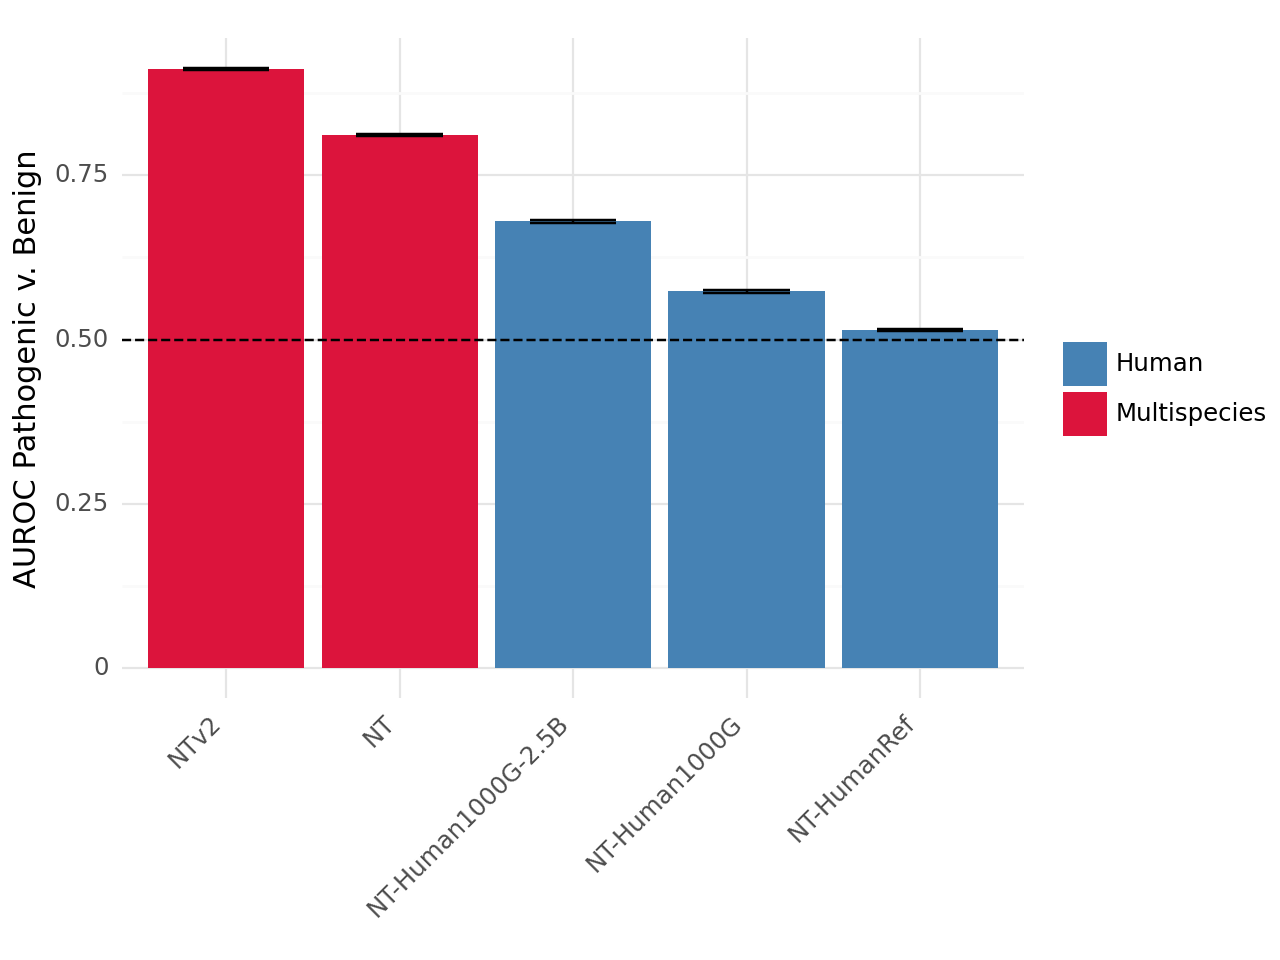

<Figure Size: (640 x 480)>

In [112]:
plot_df = plot_rocs#pd.DataFrame(roc_auc_dict,index=[0]).melt()

#plot_df = plot_df.query('variable != "phyloP447"')

plot_df["model_type"] = plot_df["variable"].apply(lambda x: model_type_dict[x])
plot_df["variable"] = pd.Categorical(plot_df["variable"],categories=model_type_dict.keys())


p = (p9.ggplot(data=plot_df, mapping=p9.aes(x="variable",y="value", fill="model_type")) 
 #+ p9.geom_boxplot(outlier_shape="") 
 + p9.geom_bar(stat="identity")
 + p9.geom_errorbar(mapping=p9.aes(x="variable", ymin="auroc_min",ymax="auroc_max"))
  + p9.geom_hline(yintercept=0.5, linetype="dashed")
 #+ p9.coord_cartesian(ylim=(0.5,1))
 #+ p9.geom_violin() 
 #+ p9.geom_jitter(width=0.25, size=2)
 + p9.scale_fill_manual(["steelblue","crimson","salmon"])
 #+ p9.scale_alpha_manual([0.5,1])
 + p9.labs(x="",y="AUROC Pathogenic v. Benign", fill="")
 + p9.theme_minimal()
 + p9.theme(
     axis_text_x=p9.element_text(rotation=45, hjust=1),
 )
)

p

# Yeast eQTL

In [113]:
import pyranges as pr

In [114]:
arabic_to_roman = {"1":"I","2":"II","3":"III","4":"IV","5":"V","6":"VI","7":"VII","8":"VIII",
                  "9":"IX","10":"X","11":"XI","12":"XII","13":"XIII","14":"XIV","15":"XV","16":"XVI"}

In [115]:
def compute_variant_effect(prbs,targets,ref_nucs,alt_nucs,positions):
    prbs = prbs.flatten(end_dim=-2)
    targets = targets.flatten()
    # select matching positions
    prbs_match = prbs[torch.tensor(positions),:]
    targets_match = targets[torch.tensor(positions)]
    print(prbs_match.shape)
    print(targets_match.shape)
    # background
    bg_prbs = prbs.mean(axis=0)#[0]
    # compute metrics
    ref_prbs = (torch.nn.functional.one_hot(targets_match,num_classes=4)*prbs_match).max(axis=1)[0]
    ref_bgs = bg_prbs[targets_match]
    alt_prbs = (torch.nn.functional.one_hot(torch.tensor(alt_nucs),num_classes=4)*prbs_match).max(axis=1)[0]
    alt_bgs = bg_prbs[alt_nucs]
    var_eff = np.log2(alt_prbs/ref_prbs)
    var_eff_bg = np.log2((alt_prbs/alt_bgs)/(ref_prbs/ref_bgs))
    return ref_prbs, var_eff, var_eff_bg

## Get conservation and nucprobs

In [116]:
conservation = torch.load(os.path.join(data_path, "scer_conservation_withoutstop_upstream/prbs.pt")).amax(axis=-1).float().reshape((6586701//1003,1003))
conservation = conservation.nan_to_num(0)

In [ ]:
dataset = pd.read_parquet(os.path.join(data_path, "saccharomyces_cerevisiae_five_prime.parquet"))
dataset = dataset.loc[dataset["five_prime_seq"].str.len() == 1003]
dataset = dataset.reset_index(drop=True).reset_index()
# determine positions in concatenated data
start = 0
starts = []
stops = []
for _,row in dataset.iterrows():
    starts.append(start)
    stops.append(start + len(row["five_prime_seq"]))
    start = start + len(row["five_prime_seq"]) 
dataset["concat_start"] = starts
dataset["concat_end"] = stops
dataset_sm = pd.read_parquet(os.path.join(data_path, "saccharomyces_cerevisiae_five_prime_repeat.parquet"))
dataset = dataset.merge(dataset_sm, on=["gene_id","transcript_id"])


snp_df = pd.read_parquet(os.path.join(data_path, "samples_upstream_kazachstania_k1_interaction/saccharomyces_cerevisiae/snp.parquet")).reset_index()
id_to_path = pd.read_parquet(os.path.join(data_path, "samples_upstream_kazachstania_k1_interaction/saccharomyces_cerevisiae/id_to_path.parquet"))
snp_df = id_to_path.merge(snp_df, on="transcript_id")

id_to_path_nucs = pd.read_parquet(os.path.join(data_path, "samples_upstream_kazachstania_k1_nucpreds/saccharomyces_cerevisiae/id_to_path.parquet")
id_to_path_nucs = id_to_path_nucs.merge(dataset[["gene_id","transcript_id"]], on="transcript_id")

out_dict_nucprobs, out_dict_onehots = get_all_prbs(id_to_path_nucs)
# concatenate in the right order
nucprobs = []
onehots = []
for _,row in tqdm.tqdm(dataset.iterrows()):
    gene_id = row["gene_id"]
    nucprobs.append(out_dict_nucprobs[gene_id])
    onehots.append(out_dict_onehots[gene_id])
nucprobs = torch.stack(nucprobs,axis=0)
onehots = torch.stack(onehots,axis=0)

100%|██████████| 244/244 [00:25<00:00,  9.70it/s]
6567it [00:00, 16468.20it/s]


In [117]:
rowsums = torch.load(os.path.join(data_path, 'rowsums_scer.pytorch'))

## Renganaath

In [119]:
variant_df = pd.read_csv(os.path.join(data_path, "renganaath_signif_vars.tsv"), sep="\t")

In [120]:
variant_df["Chromosome"] = variant_df["Variant"].apply(lambda x: x.split('_')[0].split(':')[1].replace("chr",""))
variant_df["pos"] = variant_df["Variant"].apply(lambda x: x.split('_')[-3]).astype('int') - 1
variant_df["ref"] = variant_df["Variant"].apply(lambda x: x.split('_')[-2])
variant_df["alt"] = variant_df["Variant"].apply(lambda x: x.split('_')[-1])

In [121]:
variant_df = variant_df.loc[(variant_df["ref"].str.len() == 1) & (variant_df["alt"].str.len() == 1)]

In [122]:
variant_merged = dataset.merge(variant_df,on="Chromosome").query('pos >= five_prime_start and pos < five_prime_end')
variant_merged["rel_pos"] = variant_merged.apply(lambda x: x["pos"]-x["five_prime_start"] if x["Strand"] == "+" else 1002-(x["pos"]-x["five_prime_start"]), axis=1)

In [123]:
nuc_to_number = {"A":0,"C":1,"G":2,"T":3}
nuc_to_revcomp = {"A":"T","T":"A","G":"C","C":"G"}

ref_nucs = []
alt_nucs = []
positions = []
for _,var_row in variant_merged.iterrows():
    strand = var_row["Strand"]
    ref = var_row["ref"] if strand == "+" else nuc_to_revcomp[var_row["ref"]]
    alt = var_row["alt"] if strand == "+" else nuc_to_revcomp[var_row["alt"]]
    assert ref != alt
    assert ref == var_row["five_prime_seq"][var_row["rel_pos"]], var_row["Variant"]
    abs_pos = var_row["concat_start"] + var_row["rel_pos"]
    ref_nucs.append(nuc_to_number[ref])
    alt_nucs.append(nuc_to_number[alt])
    positions.append(abs_pos)

In [124]:
targets = onehots.argmax(axis=-1).flatten()
prbs = nucprobs.flatten(end_dim=-2)
# select matching positions
prbs_match = prbs[torch.tensor(positions),:]
targets_match = targets[torch.tensor(positions)]
# compute metrics
ref_prbs = (torch.nn.functional.one_hot(targets_match,num_classes=4)*prbs_match).max(axis=1)[0]
alt_prbs = (torch.nn.functional.one_hot(torch.tensor(alt_nucs),num_classes=4)*prbs_match).max(axis=1)[0]
# var eff as log ratio
var_eff = np.log2(alt_prbs/ref_prbs)

NameError: name 'onehots' is not defined

In [68]:
variant_merged["var_eff"] = -var_eff

In [69]:
# extract row-sum
targets = onehots.argmax(axis=-1).flatten()
var_rowsums = rowsums.flatten(end_dim=-2)
# select matching positions
var_rowsums = var_rowsums[torch.tensor(positions)]
var_rowsums = (torch.nn.functional.one_hot(torch.tensor(alt_nucs),num_classes=4)*var_rowsums).amax(axis=1)
variant_merged["Interaction"] = var_rowsums

In [70]:
cons = conservation.flatten()[torch.tensor(positions)]
variant_merged["Conservation"] = cons

In [71]:
var_effects = variant_merged.sort_values('rel_pos').drop_duplicates("Variant",keep="last")

In [72]:
var_effects["sig"] = var_effects['minAdjPVal'] < 0.05
var_effects = var_effects.query('sig or minPVal > 0.2')

In [73]:
len(var_effects)

3056

In [74]:
len(var_effects.query('sig'))

379

In [ ]:
counts = susie_merged['causal_str'].value_counts()

susie_merged['causal_str_label'] = susie_merged['causal_str'].map(lambda x: f"{x}\n(N={counts[x]})")

p = (p9.ggplot(data=susie_merged, mapping=p9.aes(x="causal_str_label",y="Interaction")) 
 + p9.geom_violin(size=0.75, fill="steelblue")#, draw_quantiles=[0.25,0.5,0.75])
 + p9.geom_boxplot(width=0.25, outlier_shape="")
 #+ p9.geom_jitter(alpha=0.001)
 #+ p9.geom_violin(fill="blue", size=0.75)
 + p9.labs(x="",y="Influence score", color="")
 + p9.scale_y_log10()
 #+ p9.scale_alpha(guide=False)
 + p9.theme_minimal()
 + p9.theme(legend_text = p9.element_text(size=12),
        legend_key_size=12,
        legend_background=p9.element_blank(),
        legend_title=p9.element_text(size=12),
        axis_text_x = p9.element_text(size=12),
        legend_position=(0.8,0.3), 

/opt/modules/i12g/anaconda/envs/flash2/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6 x 4 in image.
/opt/modules/i12g/anaconda/envs/flash2/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /data/ceph/hdd/project/node_09/semi_supervised_multispecies/Downstream/Graphics/Matrices/SupFigIntro_YeastEqtl_violin.png


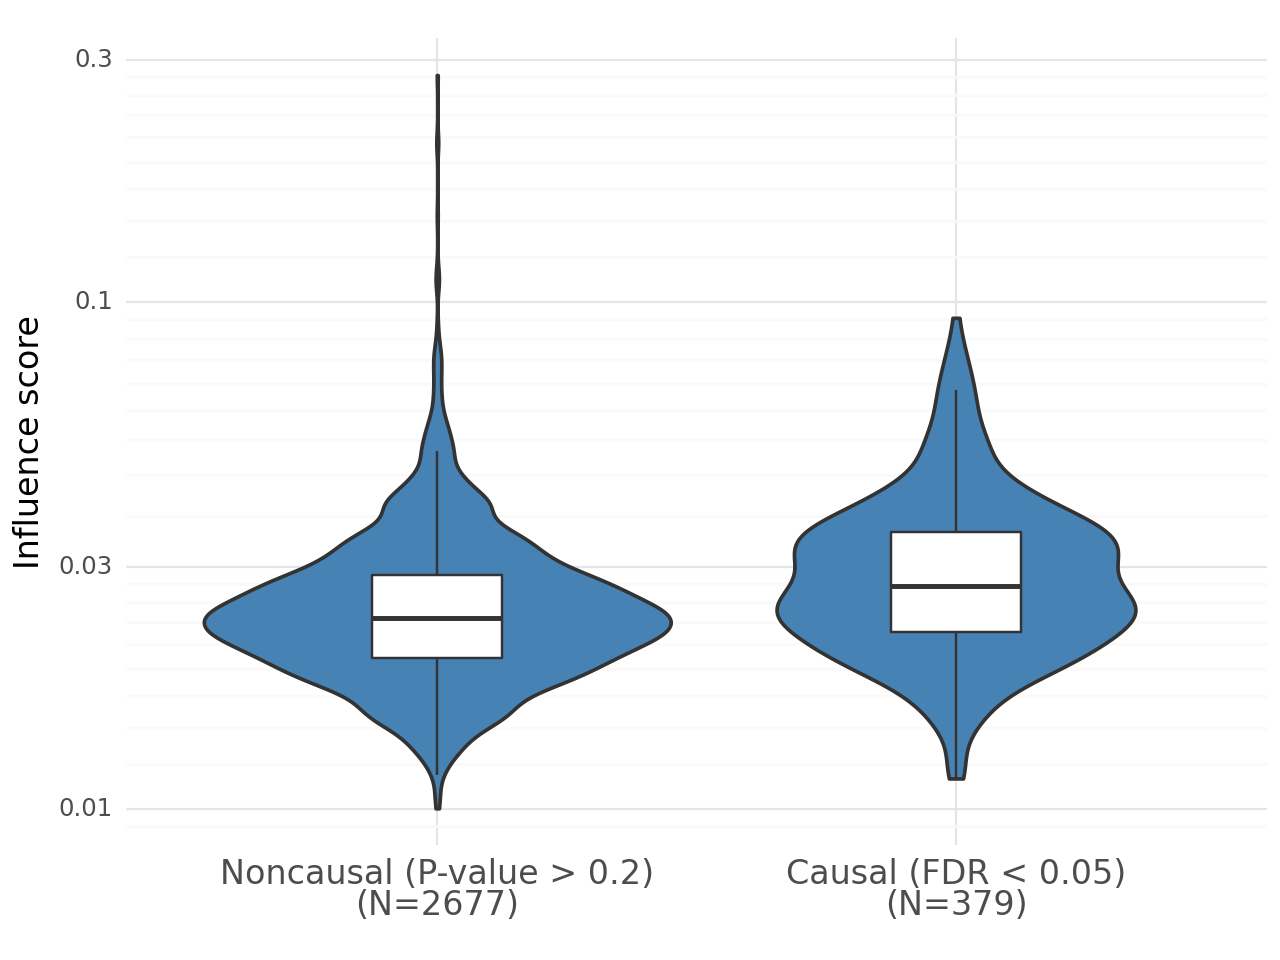

<Figure Size: (640 x 480)>

In [78]:
plot_df = var_effects.copy()
plot_df["causal_str"] = plot_df["sig"].apply(lambda x: 'Causal (FDR < 0.05)' if x else "Noncausal (P-value > 0.2)")
plot_df["causal_str"] = pd.Categorical(plot_df["causal_str"], categories=["Noncausal (P-value > 0.2)","Causal (FDR < 0.05)"])

counts = plot_df['causal_str'].value_counts()
plot_df['causal_str_label'] = plot_df['causal_str'].map(lambda x: f"{x}\n(N={counts[x]})")

p = (p9.ggplot(data=plot_df, mapping=p9.aes(x="causal_str_label",y="Interaction")) 
 + p9.geom_violin(size=0.75, fill="steelblue")#, draw_quantiles=[0.25,0.5,0.75])
 + p9.geom_boxplot(width=0.25, outlier_shape="")
 #+ p9.geom_jitter(alpha=0.001)
 #+ p9.geom_violin(fill="blue", size=0.75)
 + p9.labs(x="",y="Influence score", color="")
 + p9.scale_y_log10()
 #+ p9.scale_alpha(guide=False)
 + p9.theme_minimal()
 + p9.theme(legend_text = p9.element_text(size=12),
        legend_key_size=12,
        legend_background=p9.element_blank(),
        legend_title=p9.element_text(size=12),
        legend_position=(0.8,0.3), 
        legend_direction='vertical',
        axis_text_x = p9.element_text(size=12),
        axis_title=p9.element_text(size=12),
       )
    )


p

In [76]:
scipy.stats.mannwhitneyu(var_effects.query('sig')["Interaction"],var_effects.query('not sig')["Interaction"])

MannwhitneyuResult(statistic=642932.0, pvalue=3.256489445044722e-17)

In [77]:
scipy.stats.ranksums(var_effects.query('sig')["Interaction"],var_effects.query('not sig')["Interaction"])

RanksumsResult(statistic=8.437008664168445, pvalue=3.25562338283084e-17)

In [70]:
pred_types = {"Conservation":"Conservation",
              "var_eff":"Log-Ratio", # Reconstruction (CE)
              "Interaction":"Interaction",
             }

roc_plot_df_list = []
roc_auc_dict = {}
roc_df = var_effects.copy()
labels = var_effects["sig"]

for pred_type in pred_types:
    fpr, tpr, thresholds = roc_curve(y_true=np.array(labels), y_score=np.array(var_effects[pred_type]))
    roc_auc = roc_auc_score(y_true=np.array(labels), y_score=np.array(var_effects[pred_type]))
    roc_auc_dict[pred_types[pred_type]] = roc_auc
    roc_plot_df_list.append(pd.DataFrame({"fpr":fpr,"tpr":tpr,"roc_auc":roc_auc,"Type":pred_types[pred_type]}))
roc_plot_df = pd.concat(roc_plot_df_list)

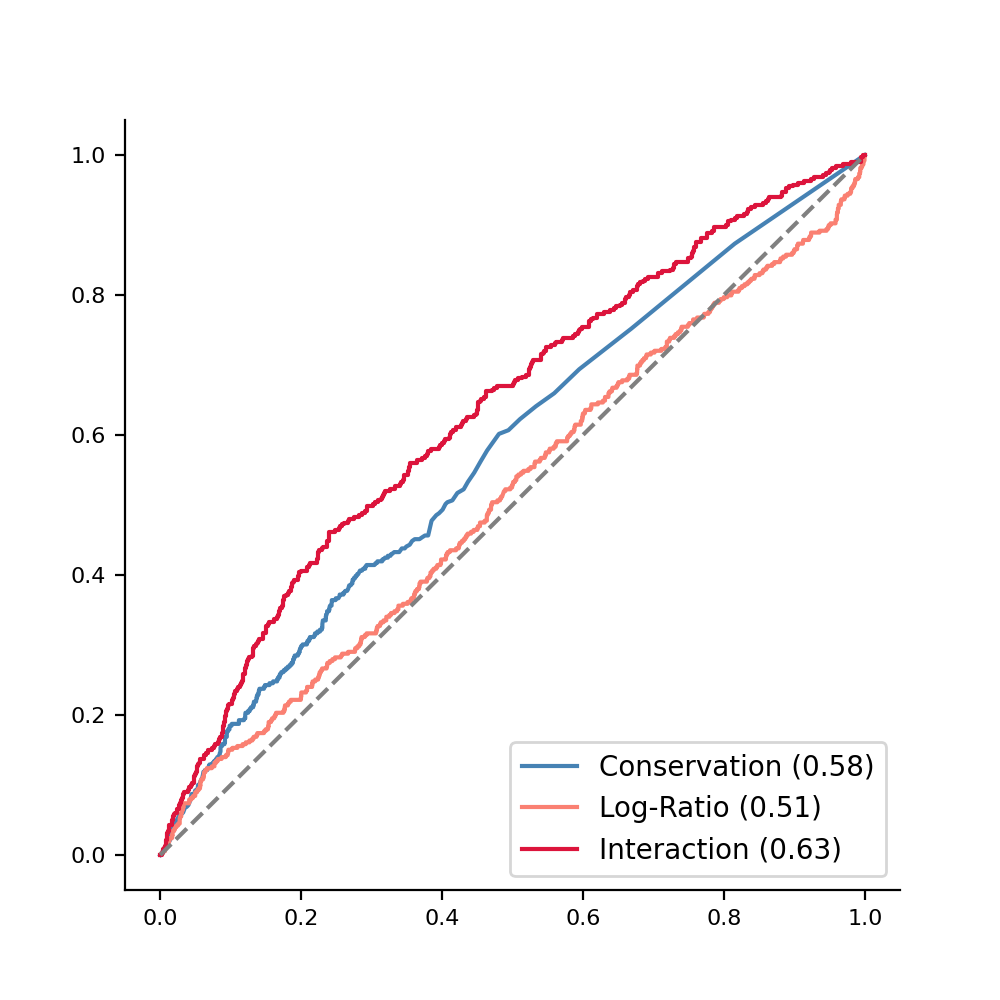

In [71]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
colors = ["steelblue","salmon","crimson","blue","crimson"]#["steelblue","lightblue","darkgreen","blue","crimson","yellow"]#["yellow","purple","green","black","blue","pink"]

for i,pred_type in enumerate(pred_types.values()):
    roc_plot_df_sub = roc_plot_df.query('Type == @pred_type')
    ax.plot(roc_plot_df_sub["fpr"],roc_plot_df_sub["tpr"], color=colors[i], label="{} ({:2.2f})".format(pred_type,roc_plot_df_sub["roc_auc"].iloc[0]))
    #ax.plot(roc_dict[model]["rec"],roc_dict[model]["prec"], color=color, label="AUPRC = {:2.2f} {}".format(roc_dict[model]["auprc"], model))
# add diagonal
ax.plot([0,1],[0,1], color='grey', linestyle='dashed')
ax.legend(loc=4)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', which='major', labelsize=8)
#ax.tick_params(axis='both', which='minor', labelsize=8)
plt.show()

In [72]:
plot_rocs = pd.DataFrame(roc_auc_dict,index=[0]).rename(columns={"Interaction":"Dependency", "Conservation":"PhastCons"}).melt()

In [74]:
rocs_samples = []
for i in tqdm.tqdm(range(100)):
    roc_df = var_effects.copy()
    roc_df = roc_df.sample(frac=1, replace=True)
    labels = roc_df["sig"]
    
    for pred_type in pred_types:
        roc_auc = roc_auc_score(y_true=np.array(labels), y_score=np.array(roc_df[pred_type]))
        roc_auc_dict[pred_types[pred_type]] = roc_auc
    
    rocs_samples.append(pd.DataFrame(roc_auc_dict,index=[0]).rename(columns={"Interaction":"Dependency", "Conservation":"PhastCons"}).melt())

100%|██████████| 100/100 [00:00<00:00, 127.43it/s]


In [75]:
rocs_sample = pd.concat(rocs_samples)

In [76]:
plot_rocs = plot_rocs.merge(rocs_sample.groupby('variable')['value'].std().reset_index().rename(columns={"value":"std"}), on="variable")

In [77]:
plot_rocs

,variable,value,std
0,PhastCons,0.576034,0.015145
1,Log-Ratio,0.512982,0.017456
2,Dependency,0.633691,0.015352


In [78]:
plot_rocs["auroc_max"] = plot_rocs["value"] + 2*plot_rocs["std"]
plot_rocs["auroc_min"] = plot_rocs["value"] - 2*plot_rocs["std"]

/opt/modules/i12g/anaconda/envs/flash2/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 6 x 4 in image.
/opt/modules/i12g/anaconda/envs/flash2/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: /data/ceph/hdd/project/node_09/semi_supervised_multispecies/Downstream/Graphics/Matrices/SupFigIntro_YeastEqtl_bar.png


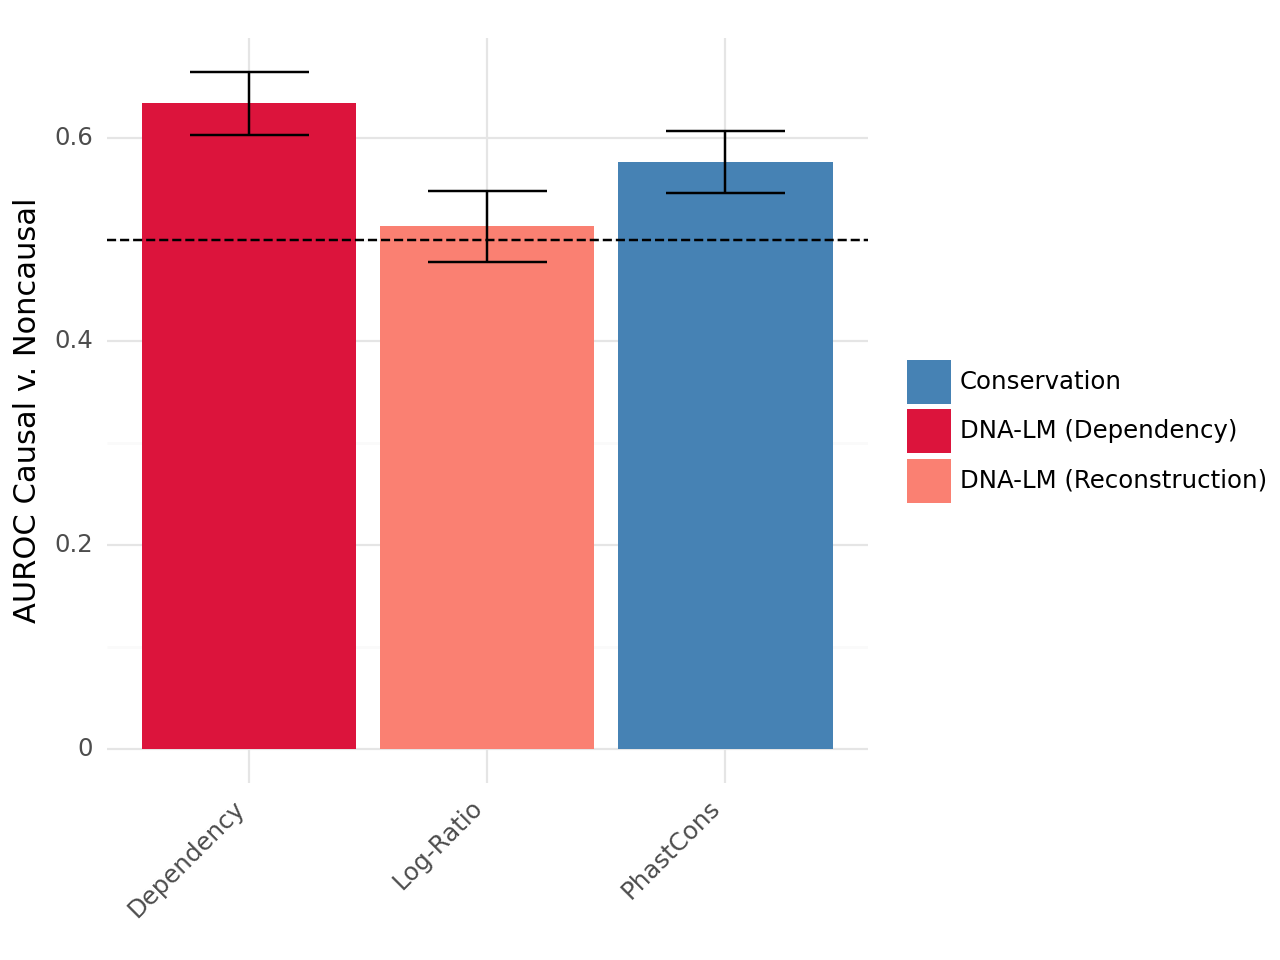

<Figure Size: (640 x 480)>

In [87]:
model_type_dict = {
    "Dependency":"DNA-LM (Dependency)",
    "Log-Ratio":"DNA-LM (Reconstruction)",
    "PhyloP":"Conservation",
    "PhyloP447":"Conservation",
    "PhyloP470":"Conservation",
    "PhastCons":"Conservation",
    "PhastCons470":"Conservation",
}

plot_df = plot_rocs#pd.DataFrame(roc_auc_dict,index=[0]).melt()

#plot_df = plot_df.query('variable != "phyloP447"')

plot_df["model_type"] = plot_df["variable"].apply(lambda x: model_type_dict[x])
plot_df["variable"] = pd.Categorical(plot_df["variable"],categories=model_type_dict.keys())


p = (p9.ggplot(data=plot_df, mapping=p9.aes(x="variable",y="value", fill="model_type")) 
 #+ p9.geom_boxplot(outlier_shape="") 
 + p9.geom_bar(stat="identity")
 + p9.geom_errorbar(mapping=p9.aes(x="variable", ymin="auroc_min",ymax="auroc_max"))
 + p9.geom_hline(yintercept=0.5, linetype="dashed")
 #+ p9.coord_cartesian(ylim=(0.5,1))
 #+ p9.geom_violin() 
 #+ p9.geom_jitter(width=0.25, size=2)
 + p9.scale_fill_manual(["steelblue","crimson","salmon"])
 #+ p9.scale_alpha_manual([0.5,1])
 + p9.labs(x="",y="AUROC Causal v. Noncausal", fill="")
 + p9.theme_minimal()
 + p9.theme(
     axis_text_x=p9.element_text(rotation=45, hjust=1),
 )
)

#p.save("SupFigIntro_YeastEqtl_bar" + ".png", width=6, height=4, dpi=300)

p